## Housekeeping

In [639]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from IPython.display import Image
import pydotplus
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math


## Preamble - Data Cleaning

To clean our data, we have reused some of the code we had employed earlier on in the course in our first assignment. We first concatenate these files in the below cell block, and run this file through our scrubber which is where we handle our data cleaning. For further details, you can review the scrubber notebook: Data_Scrubber.ipynb.

In [640]:
#Combining the two datasets and saving as a new csv
df1 = pd.read_csv('covid19-cdc-22207000.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
df2 = pd.read_csv('covid19-cdc-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

combined_df = pd.concat([df1, df2])

combined_df.to_csv('covid19-cdc-combined-22207000-12468998.csv', index=False)

print(len(combined_df))

40000


The out of our data scrubber is <b>finalised-covid19-cdc-combined-22207000-12468998.csv</b>. This is the file we will use to train/test our models.

In [641]:
#Reading the post-scrubbed CSV and checking length
df = pd.read_csv('finalised-covid19-cdc-combined-22207000-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

print(len(df))

35348


# Task 1: Data Understanding and Preparation

# 1.1 Train/Test Split

With the data cleaning taken care of, we can now conduct a train text split on the data to prepare it for future machine learning tasks. Once the data is split, we can plot the train frame and investigate the relationships between the features.

In [642]:
#data for task 1
df = pd.read_csv('finalised-covid19-cdc-combined-22207000-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

#train test split on data
train, test = train_test_split(df, test_size = 0.3, random_state=42)

In [643]:
df.duplicated().sum()

6518

In [644]:
train.shape

(24743, 15)

In [645]:
test.shape

(10605, 15)

# 1.2 Mapping our Training Set

## Correlation Between Continuous Features

Correlation:  0.009866319950316511
Weak positive correlation between these two variables.


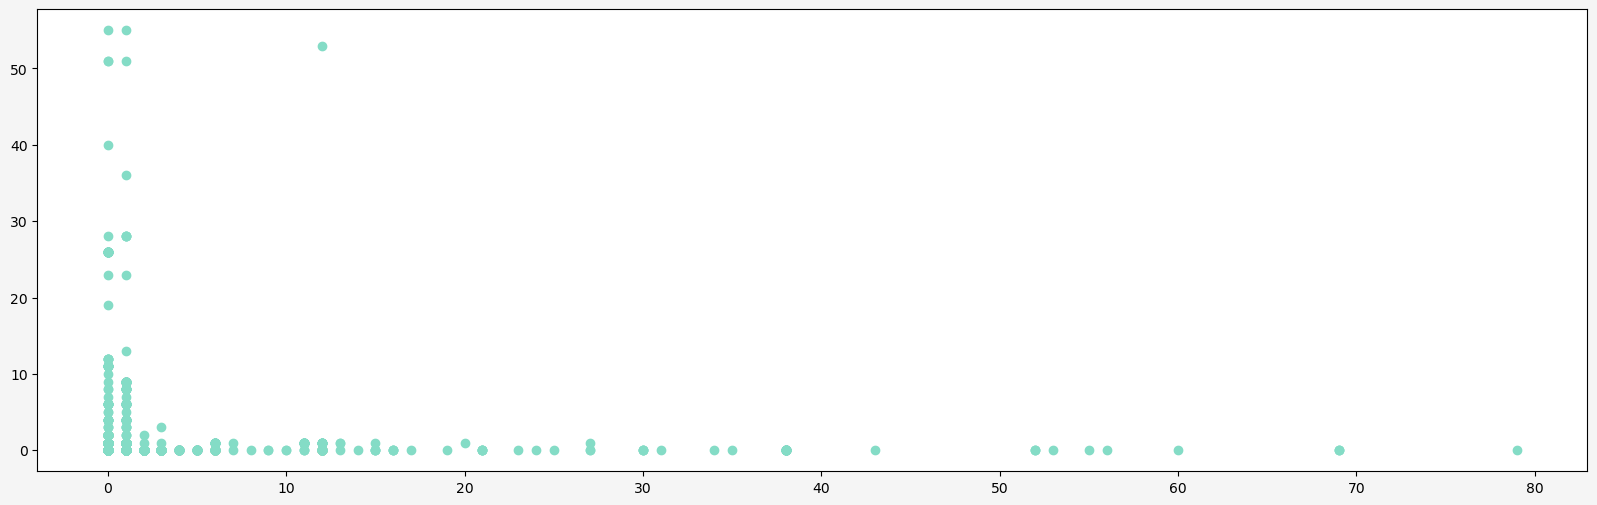

In [646]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
fig.set_facecolor('#f5f5f5')

plt.scatter(train['case_positive_specimen_interval'], train['case_onset_interval'], c='#84dcc6')
corr = train['case_onset_interval'].corr(train['case_positive_specimen_interval'])
print('Correlation: ', corr)
print('Weak positive correlation between these two variables.')
plt.show()


## Continuous Features Plotted Against Death

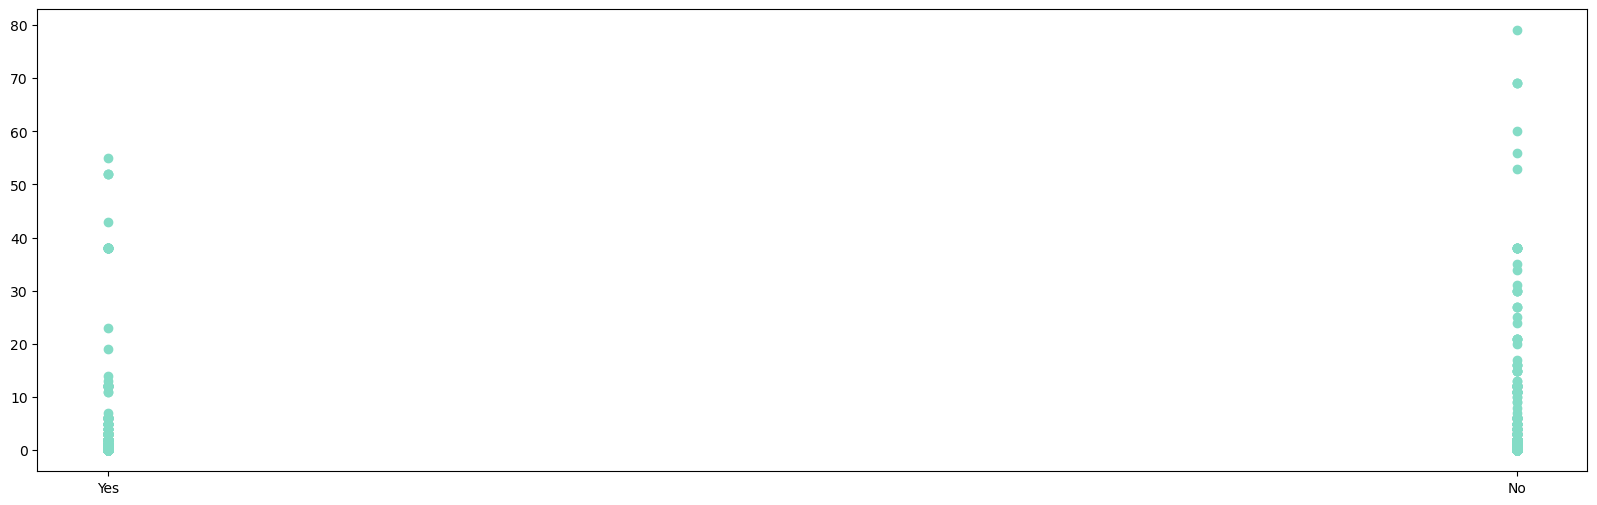

In [647]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
plt.scatter(train['death_yn'], train['case_positive_specimen_interval'], c='#84dcc6')
plt.show()

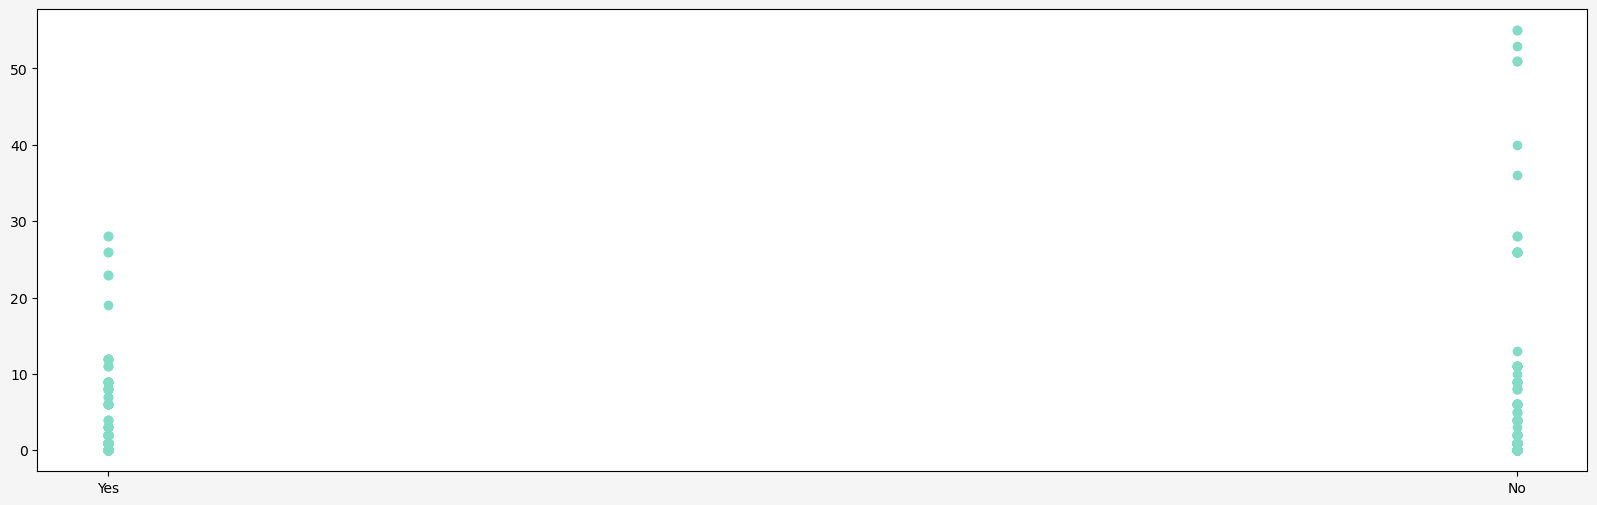

In [648]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
fig.set_facecolor('#f5f5f5')
plt.scatter(train['death_yn'], train['case_onset_interval'], c='#84dcc6')
plt.show()

## Health Related Categorical Features Plotted Against Death

Here we are looking discern patterns from our dataset by plotting deaths (yes/no) against a select number of categorical features. The features we are going to examine first are those that relate to the health profile of our patients:

1. When the patient contracted COVID.
2. What US state the patient was in when they were reported of having COVID.
3. What age group the patient belongs to.
4. Whether the patient knew if they were exposed to COVID.
5. Whether or not the patient was hospitalised or not.
6. Whether or not the patient was taken to ICU.
7. And whether or not the patient exhibited underlying conditions which could exacerbate COVID.

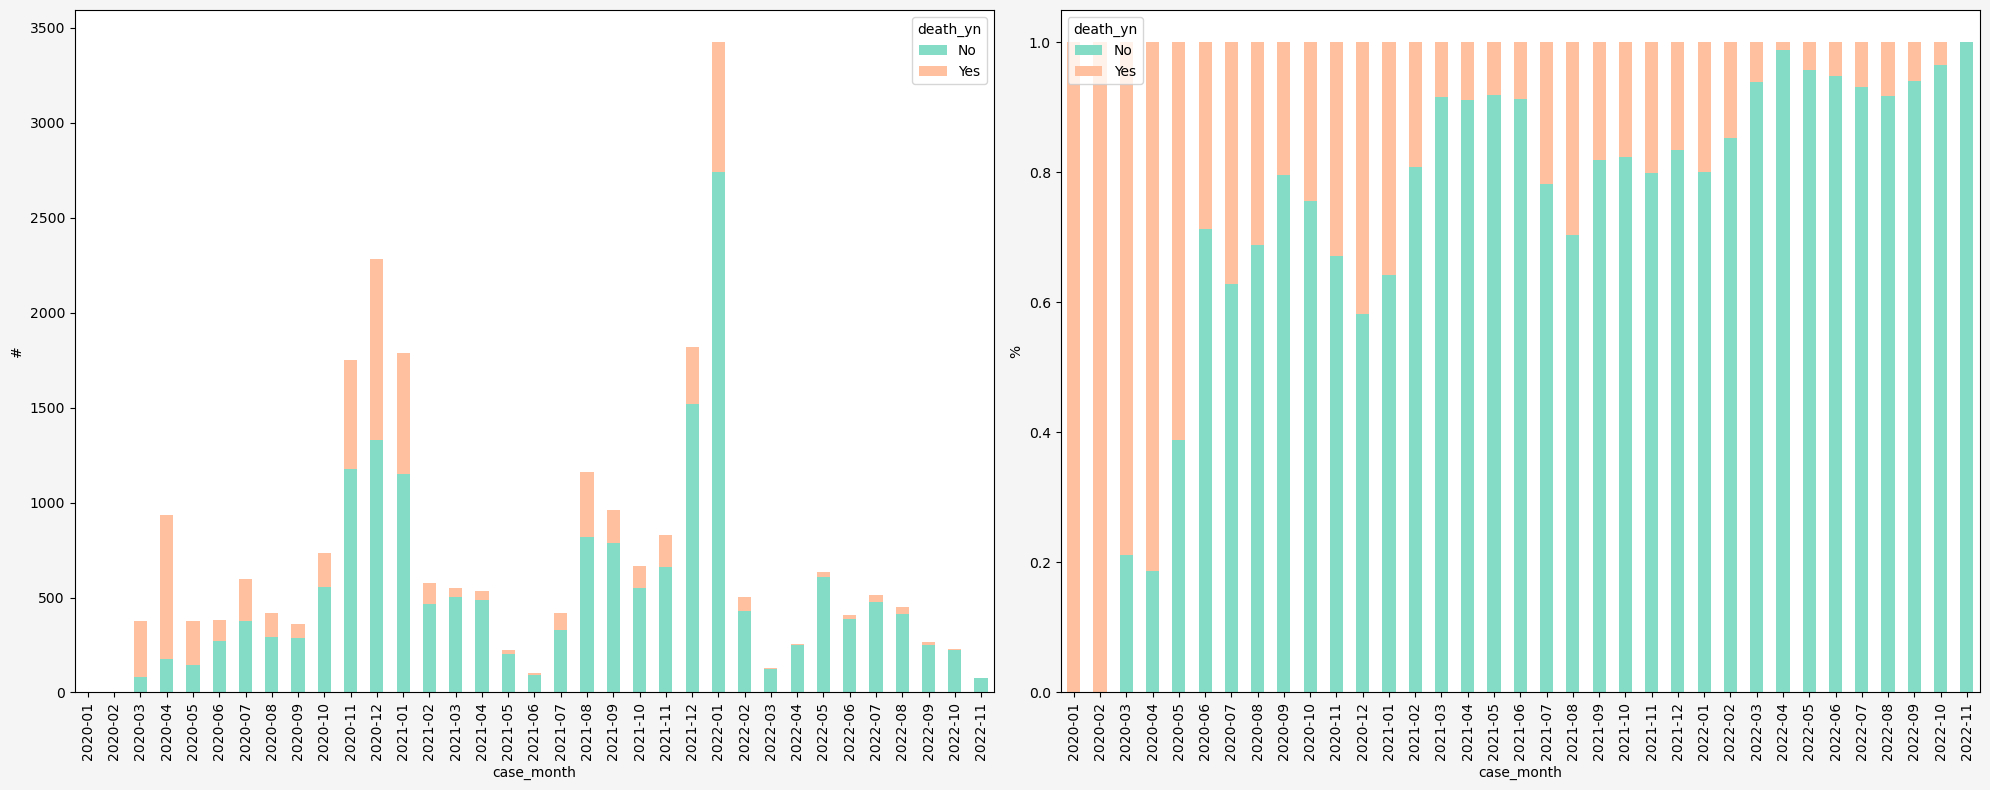

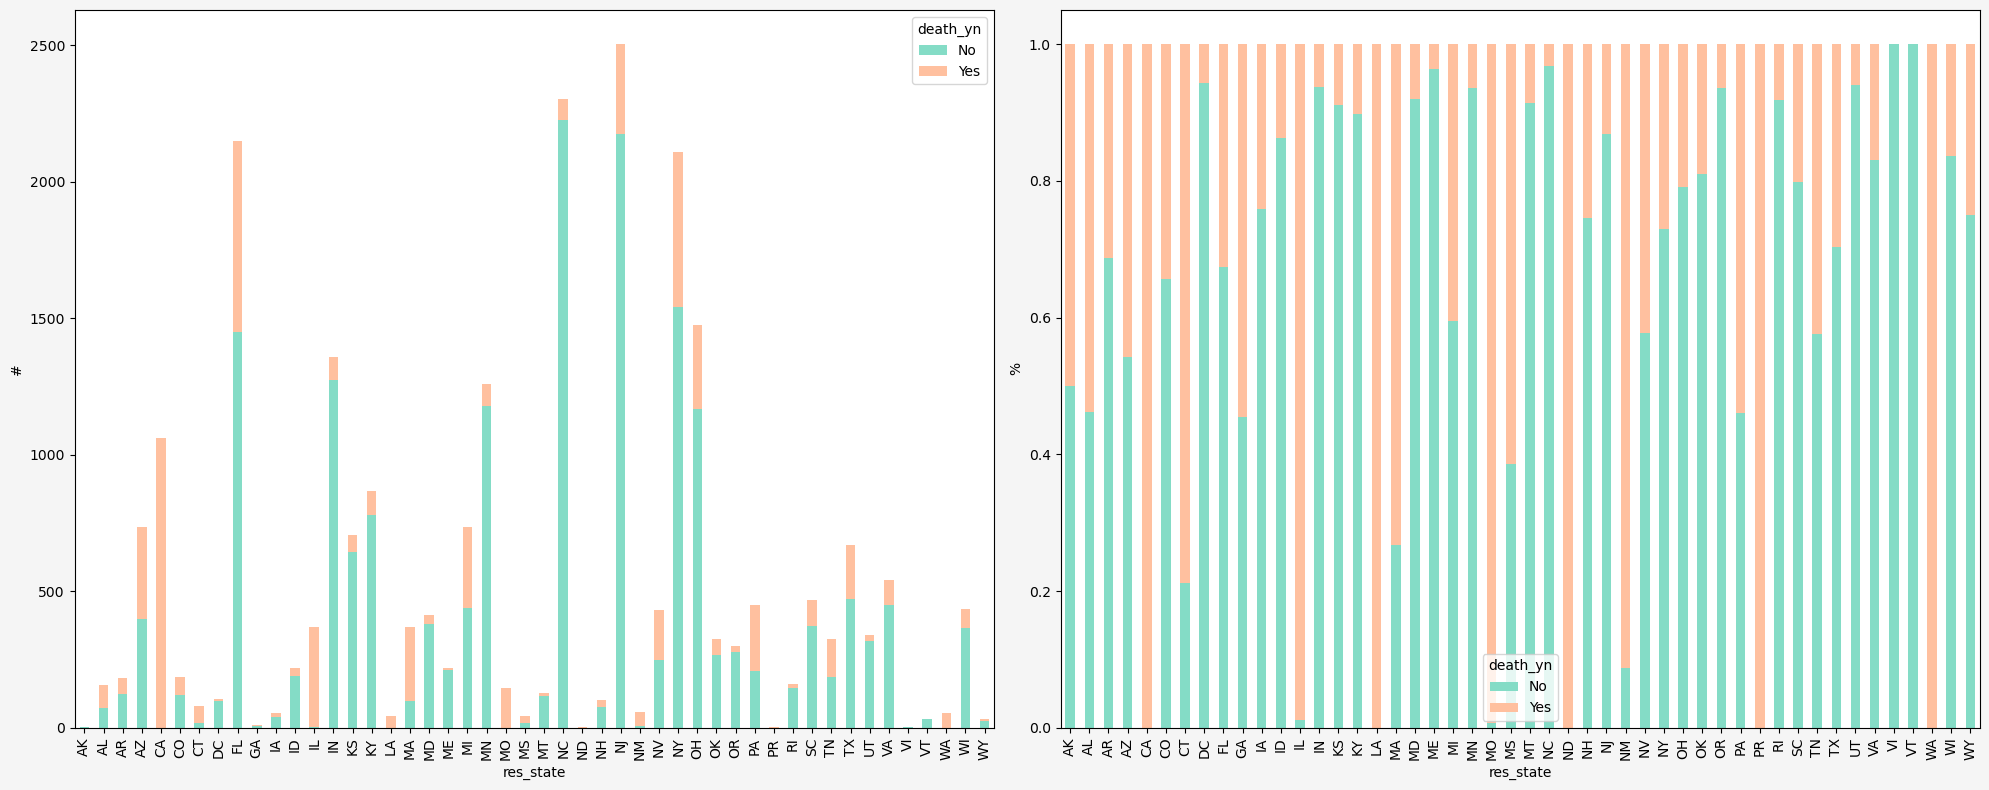

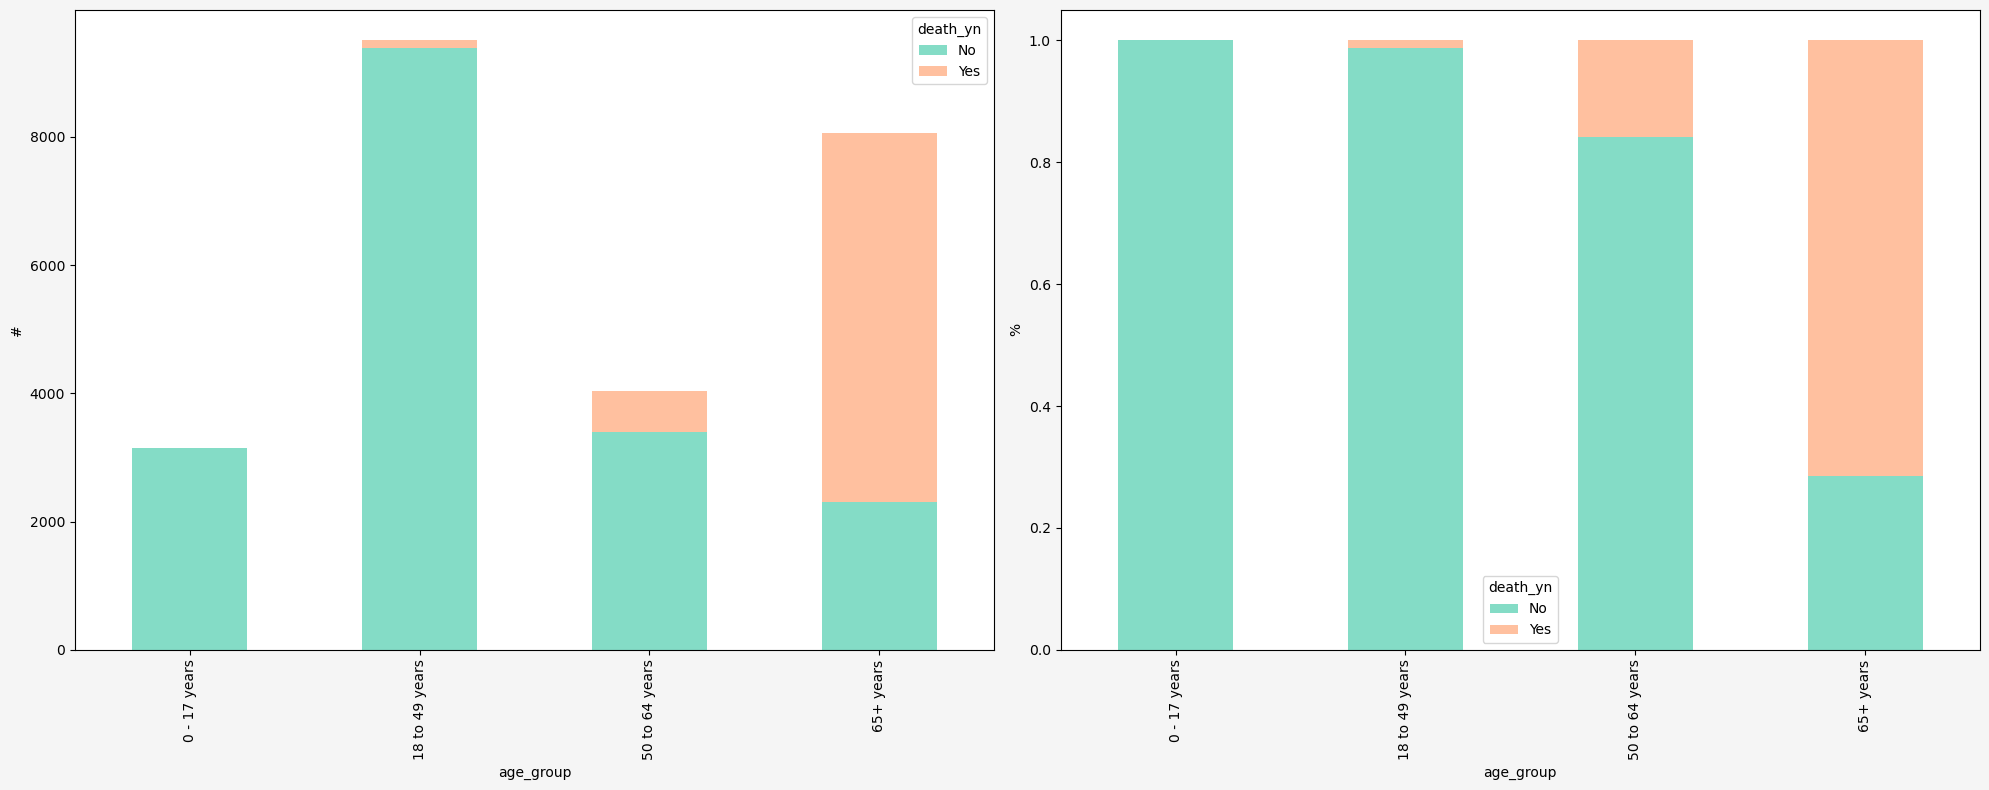

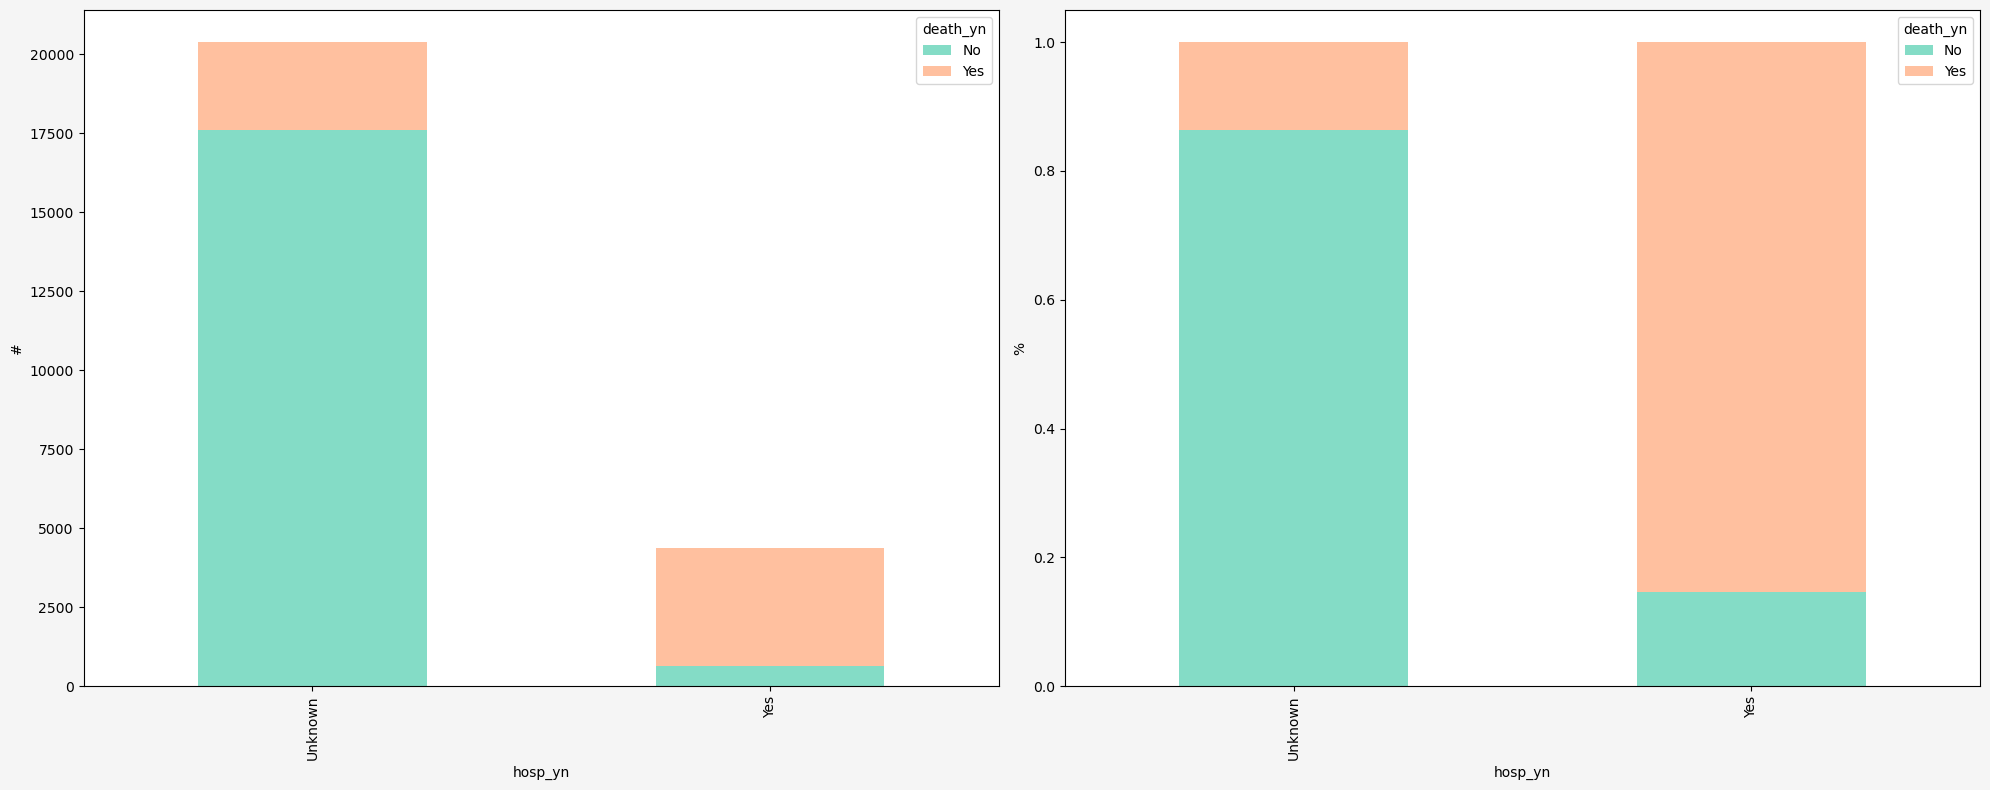

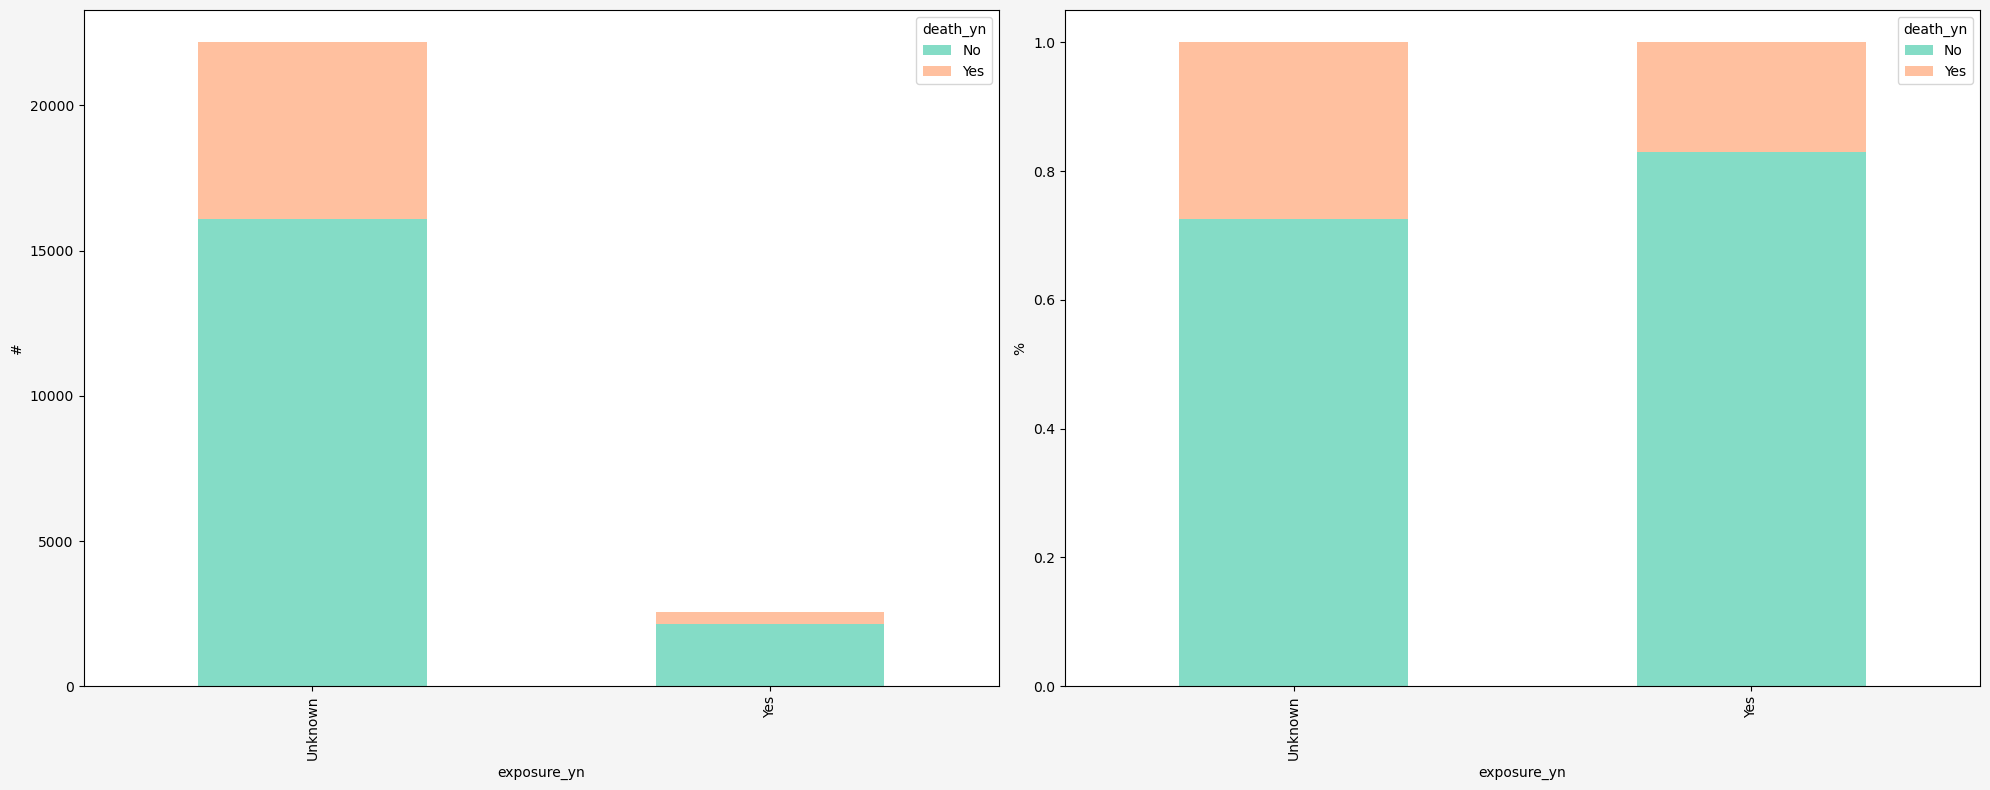

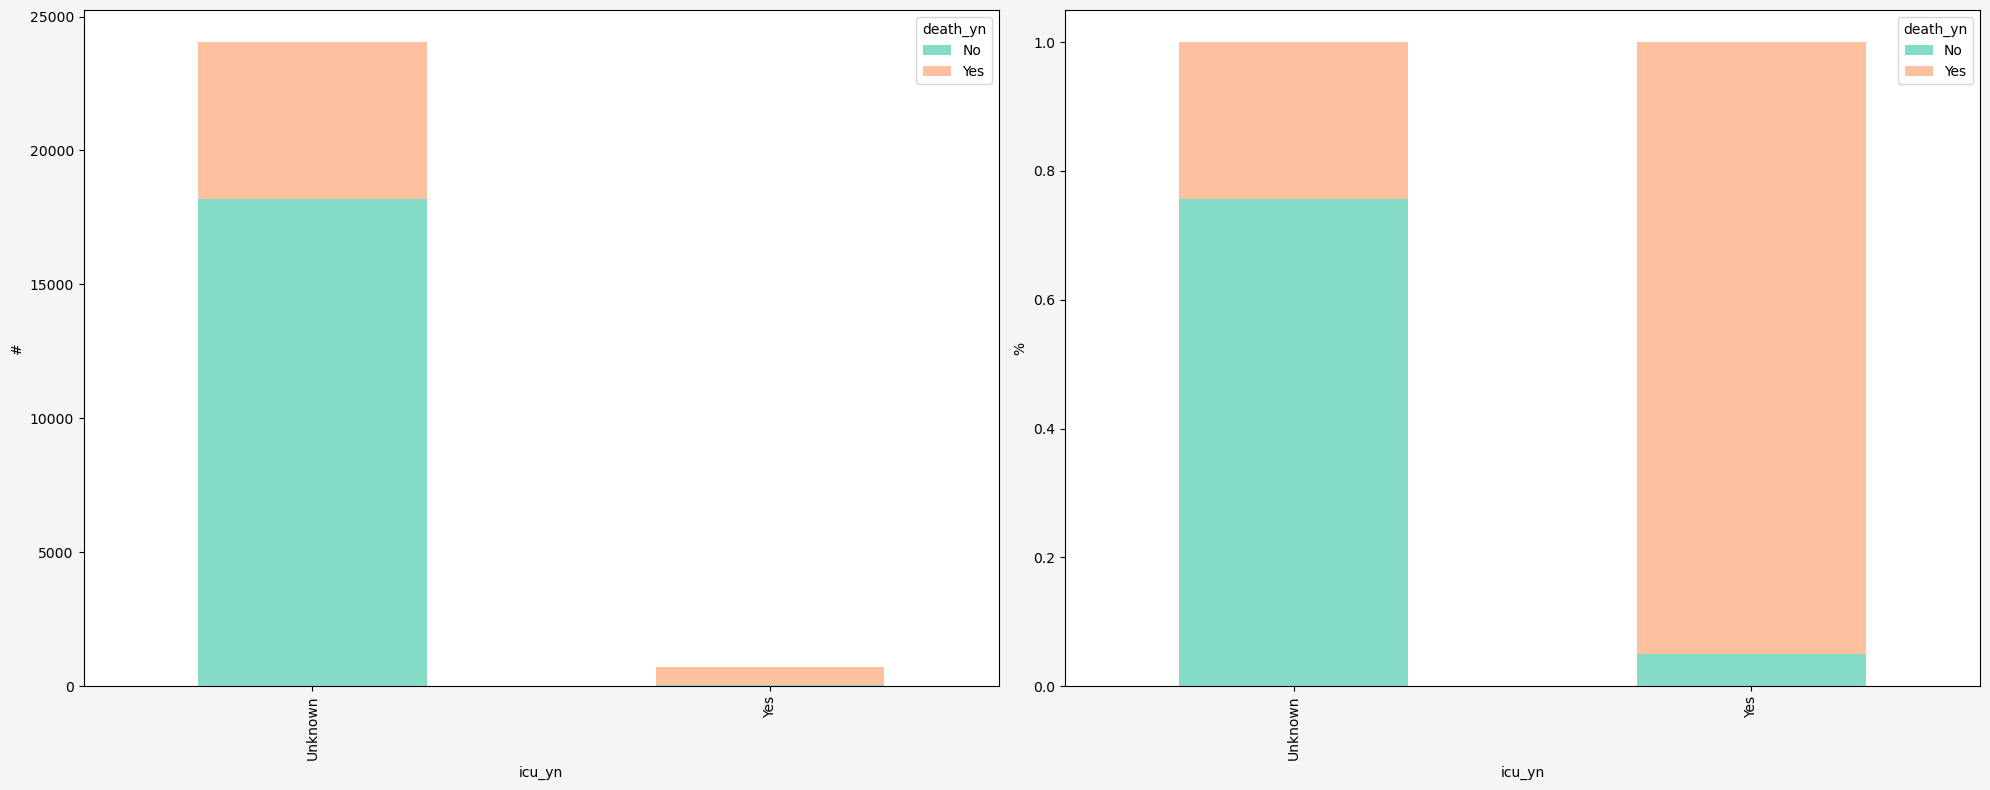

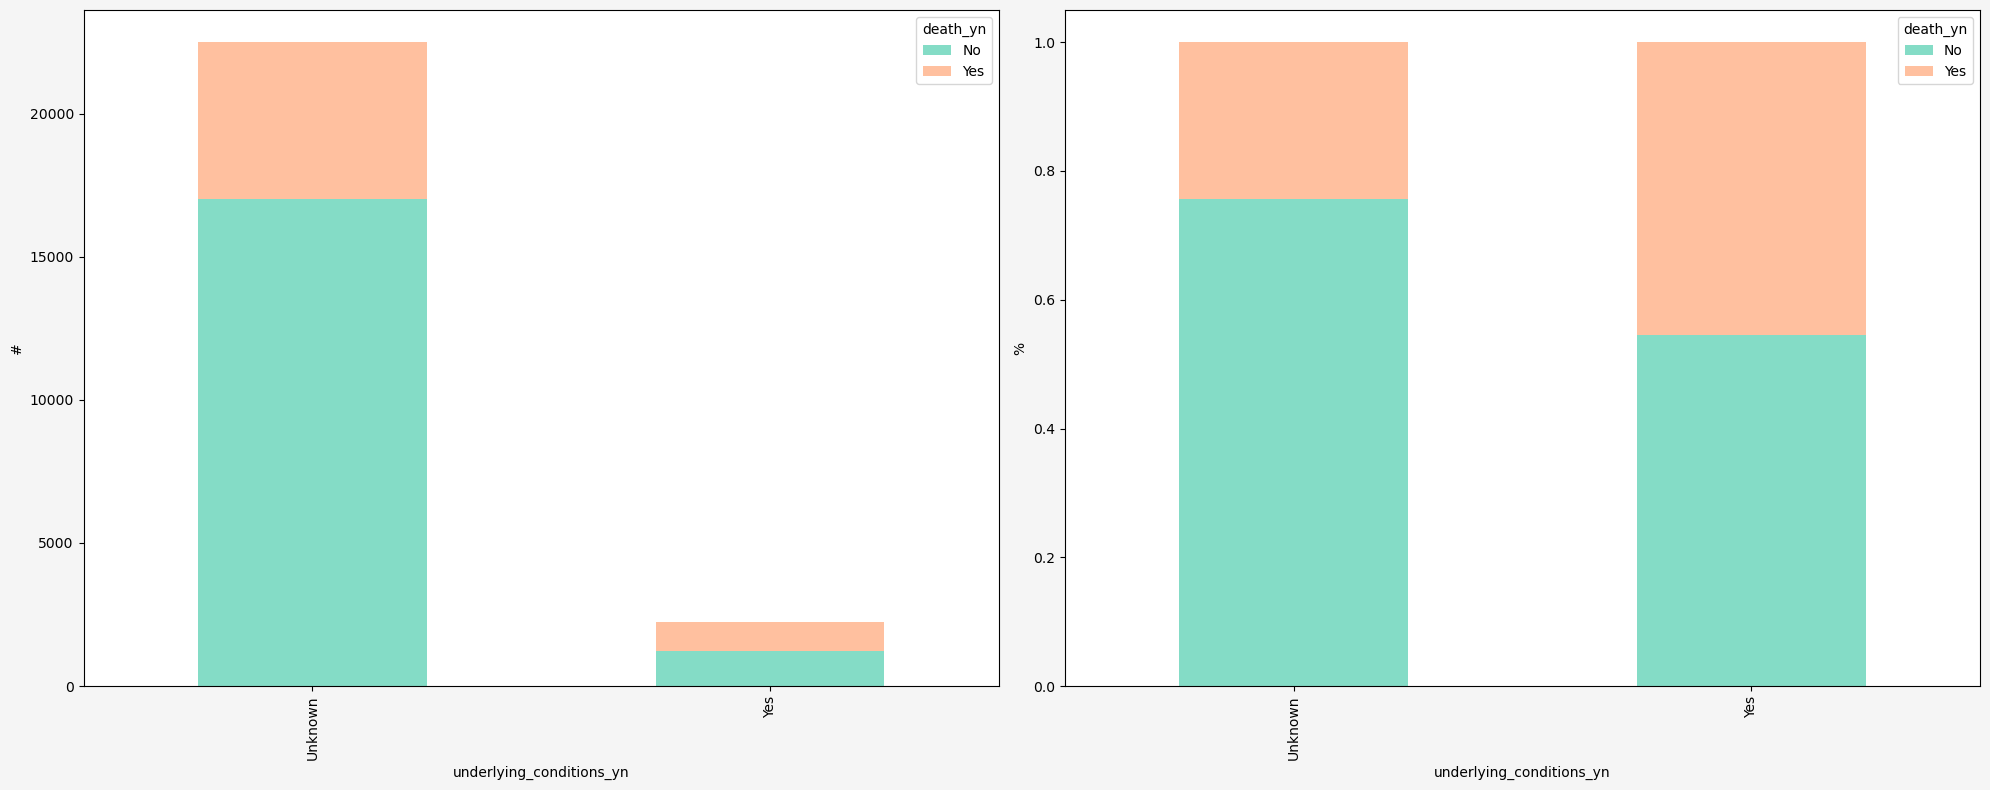

In [649]:
target_feature = train['death_yn']
select_features = [train['case_month'], train['res_state'], train['age_group'], train['hosp_yn'], train['exposure_yn'], train['icu_yn'], train['underlying_conditions_yn']]

colours = ['#84dcc6', '#ffc09f']

for feature in select_features:
  
    fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
    train.groupby([feature, target_feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0], color=colours)
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
    axs[0].set_ylabel('#')

    train.groupby([feature, target_feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1], color=colours)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
    axs[1].set_ylabel('%')
    
    fig.set_facecolor('#f5f5f5')
    plt.tight_layout()
    plt.show()

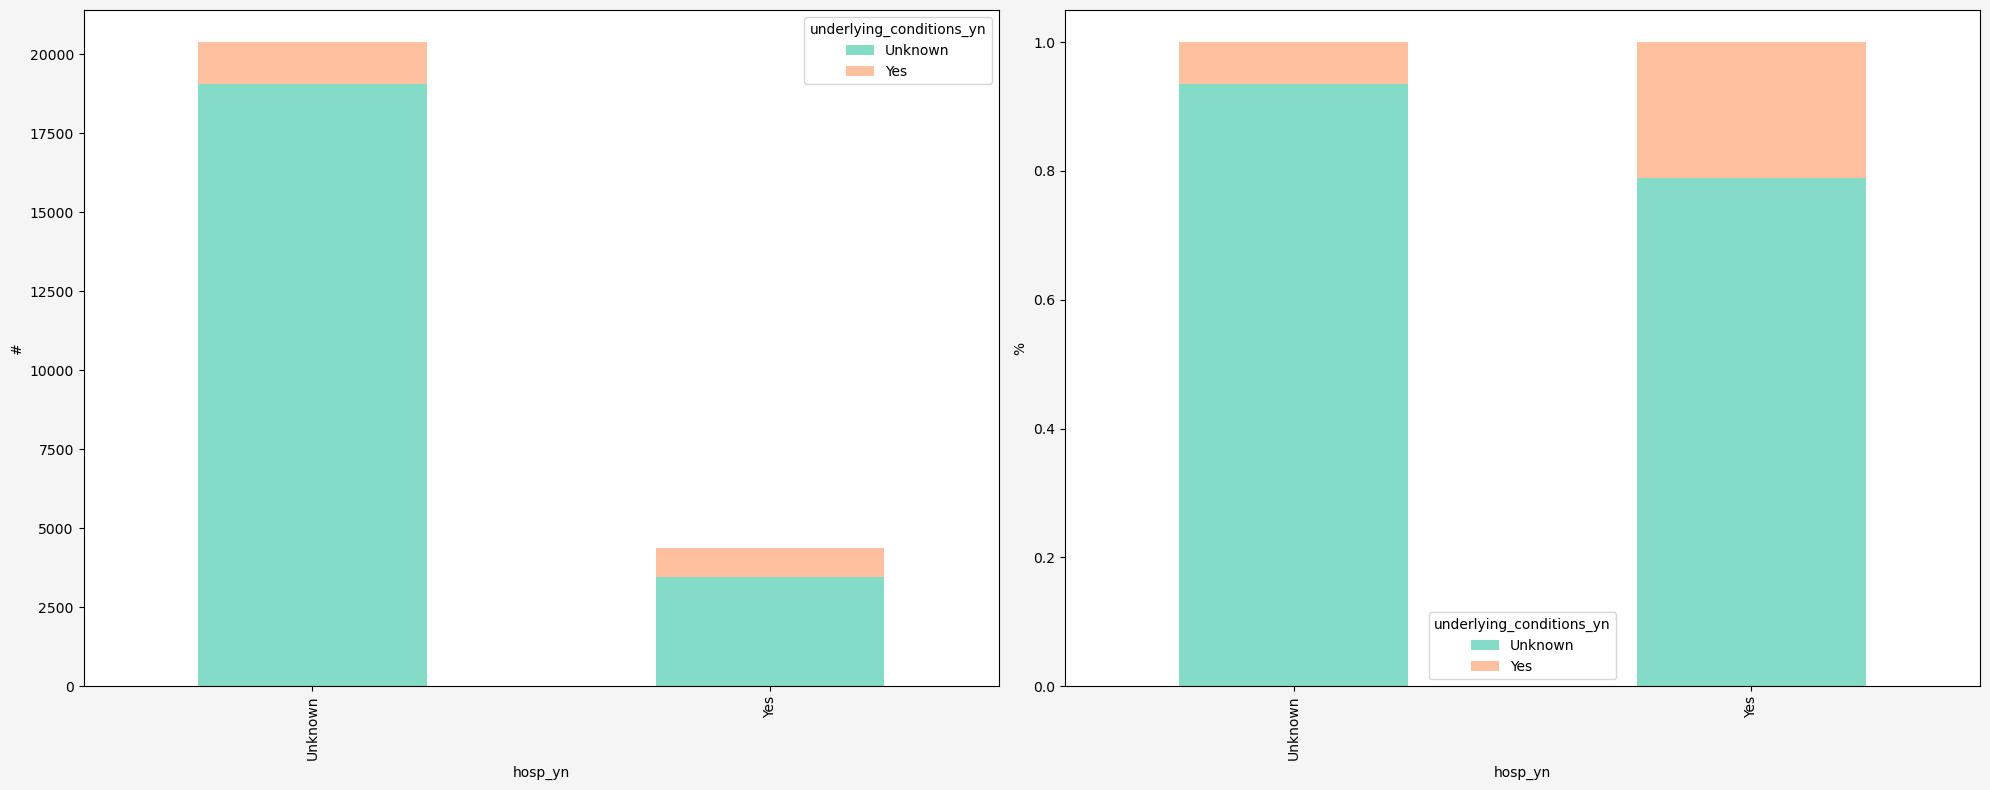

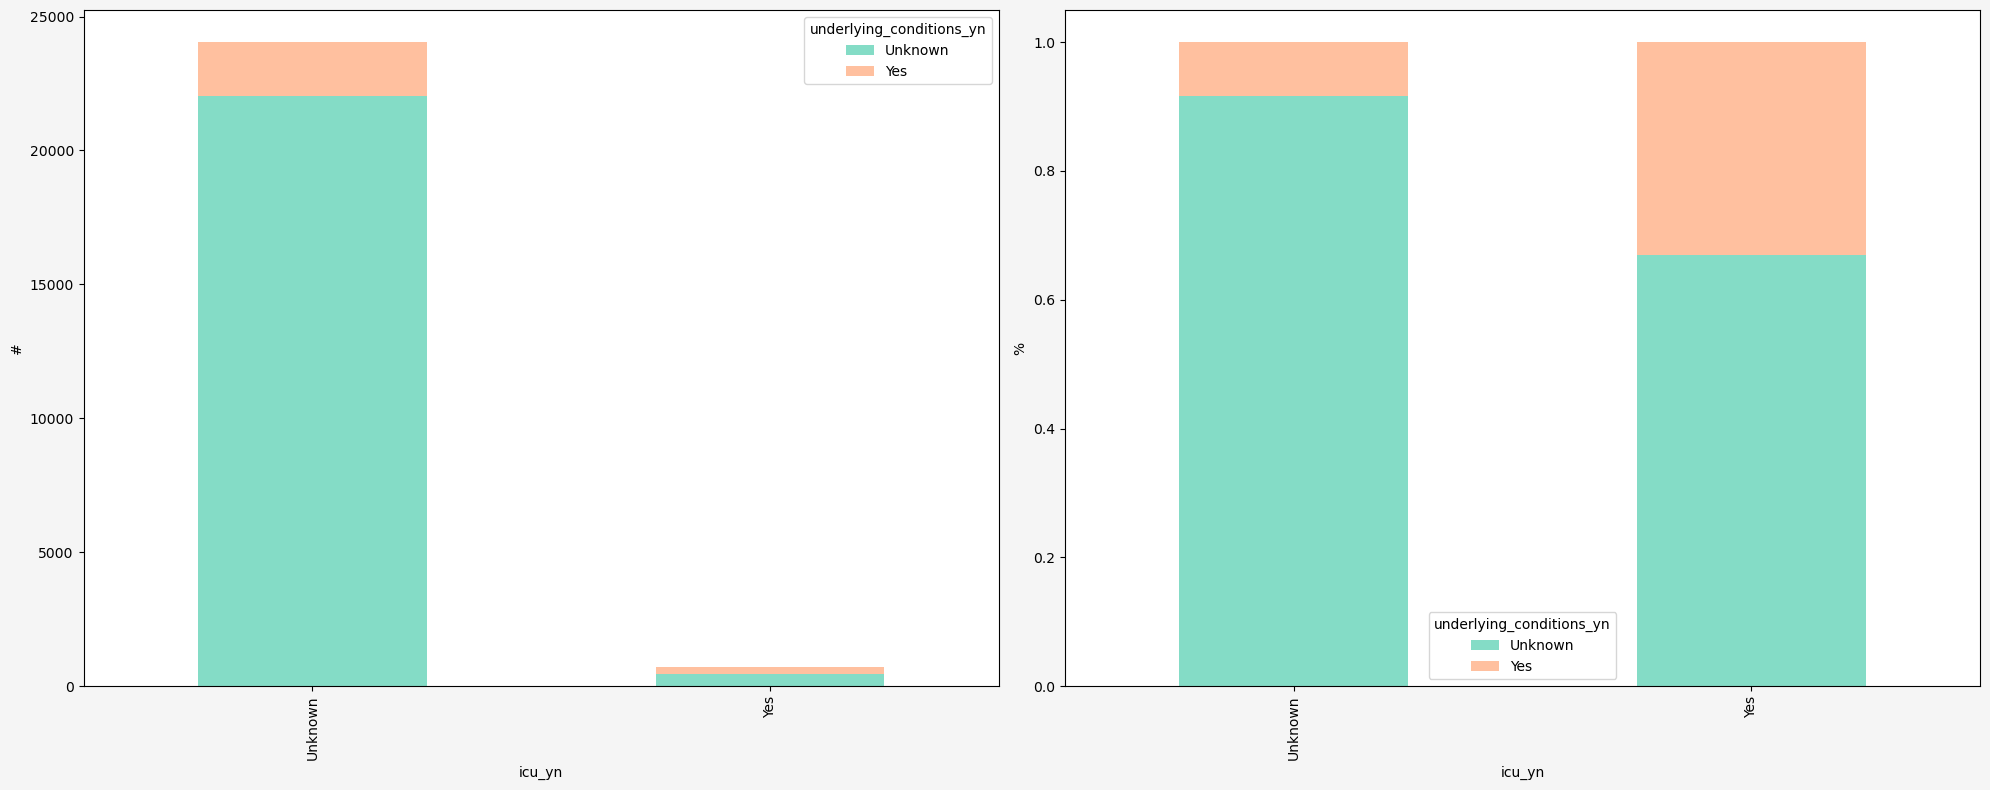

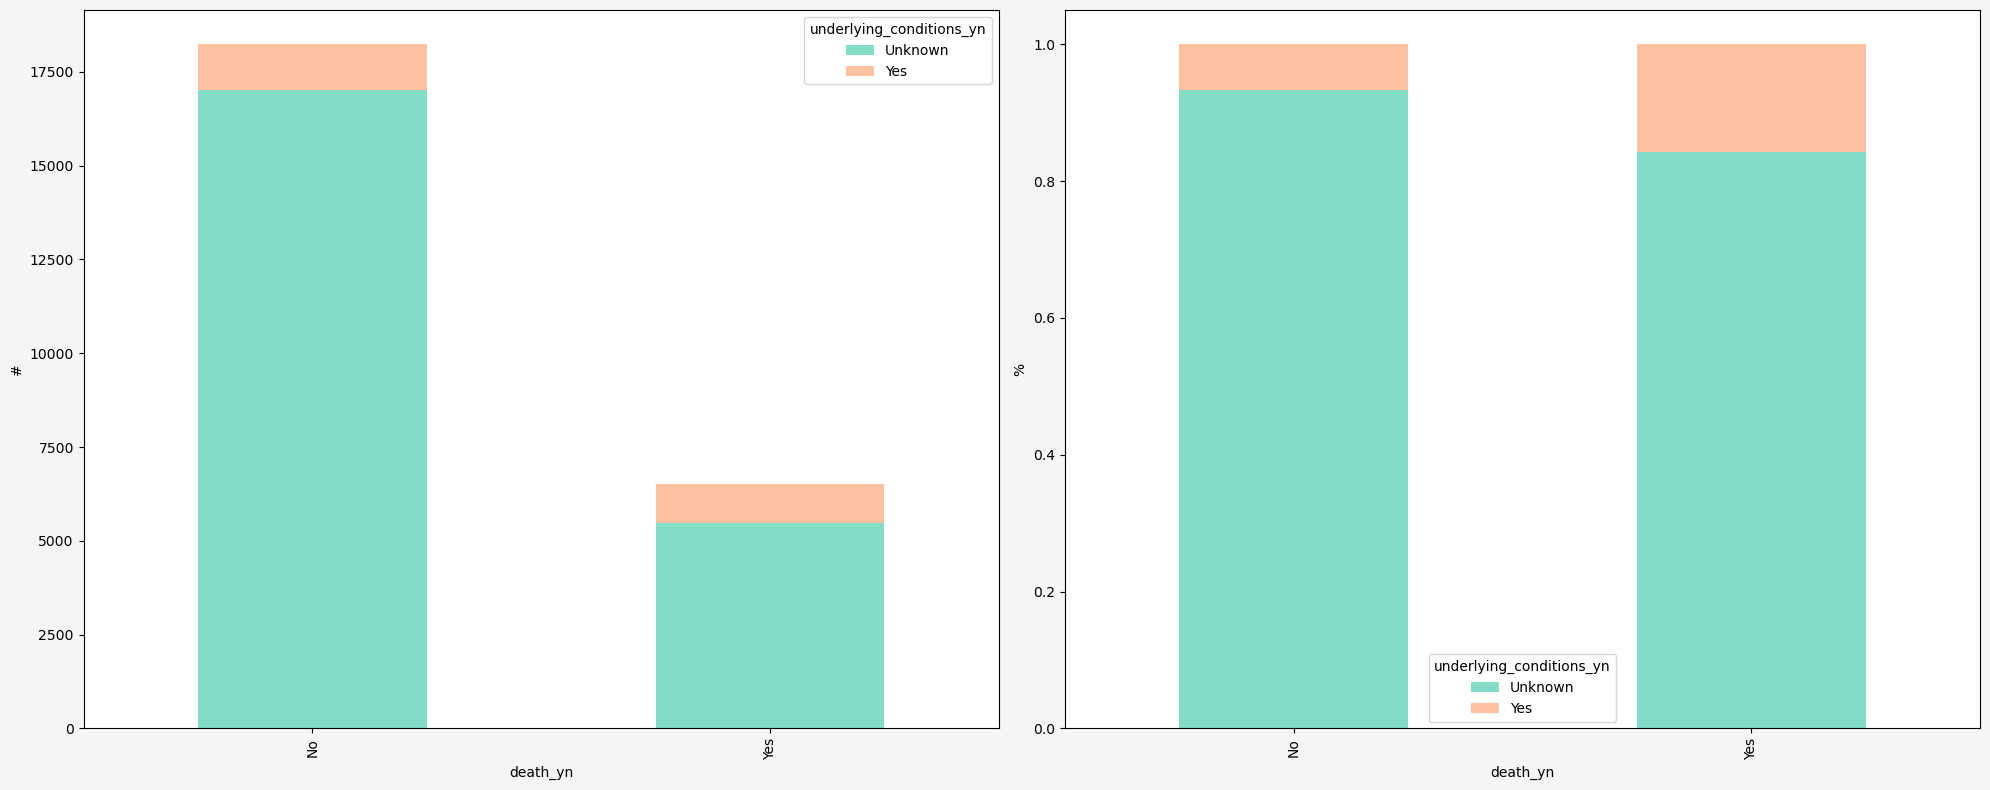

In [650]:
target_feature = train['underlying_conditions_yn']
select_features = [train['hosp_yn'], train['icu_yn'], train['death_yn']]

colours = ['#84dcc6', '#ffc09f']

for feature in select_features:
  
    fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
    train.groupby([feature, target_feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0], color=colours)
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
    axs[0].set_ylabel('#')

    train.groupby([feature, target_feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1], color=colours)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
    axs[1].set_ylabel('%')
    
    fig.set_facecolor('#f5f5f5')
    plt.tight_layout()
    plt.show()

## Sociological Related Categorical Features Plotted Against Death

Here we are looking discern patterns from our dataset by plotting deaths (yes/no) against a number of sociological features: race, ethnicity, sex.

1. The race of the patient.
2. The ethnicity of the patient.
3. The sex of the patient.

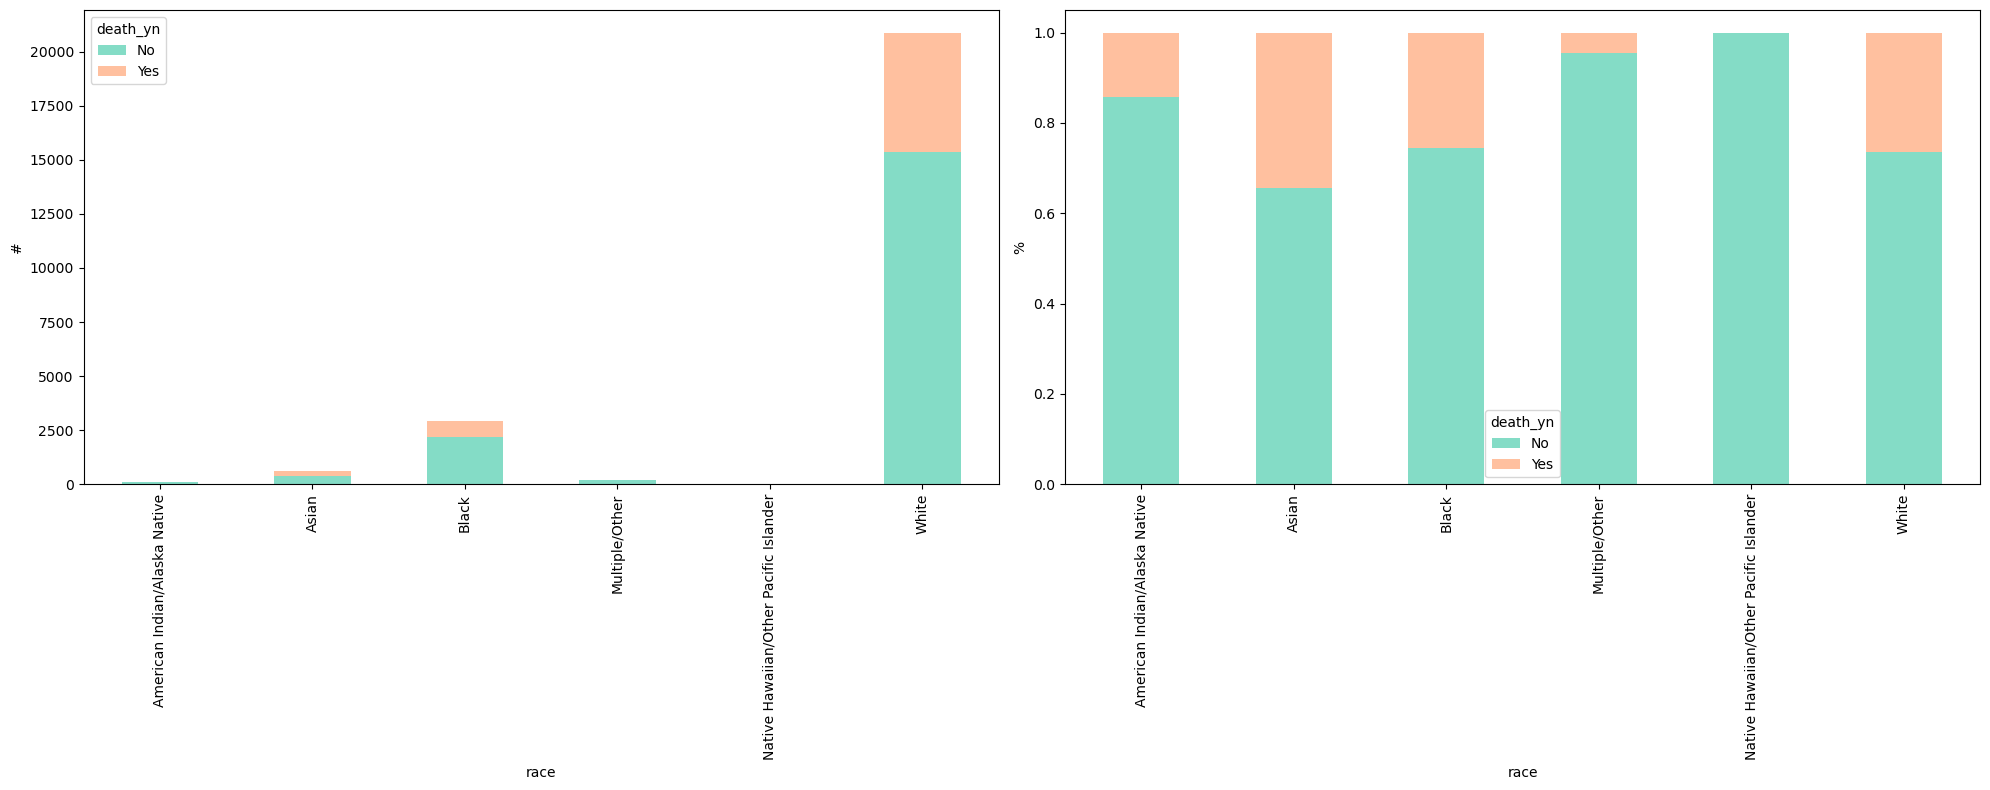

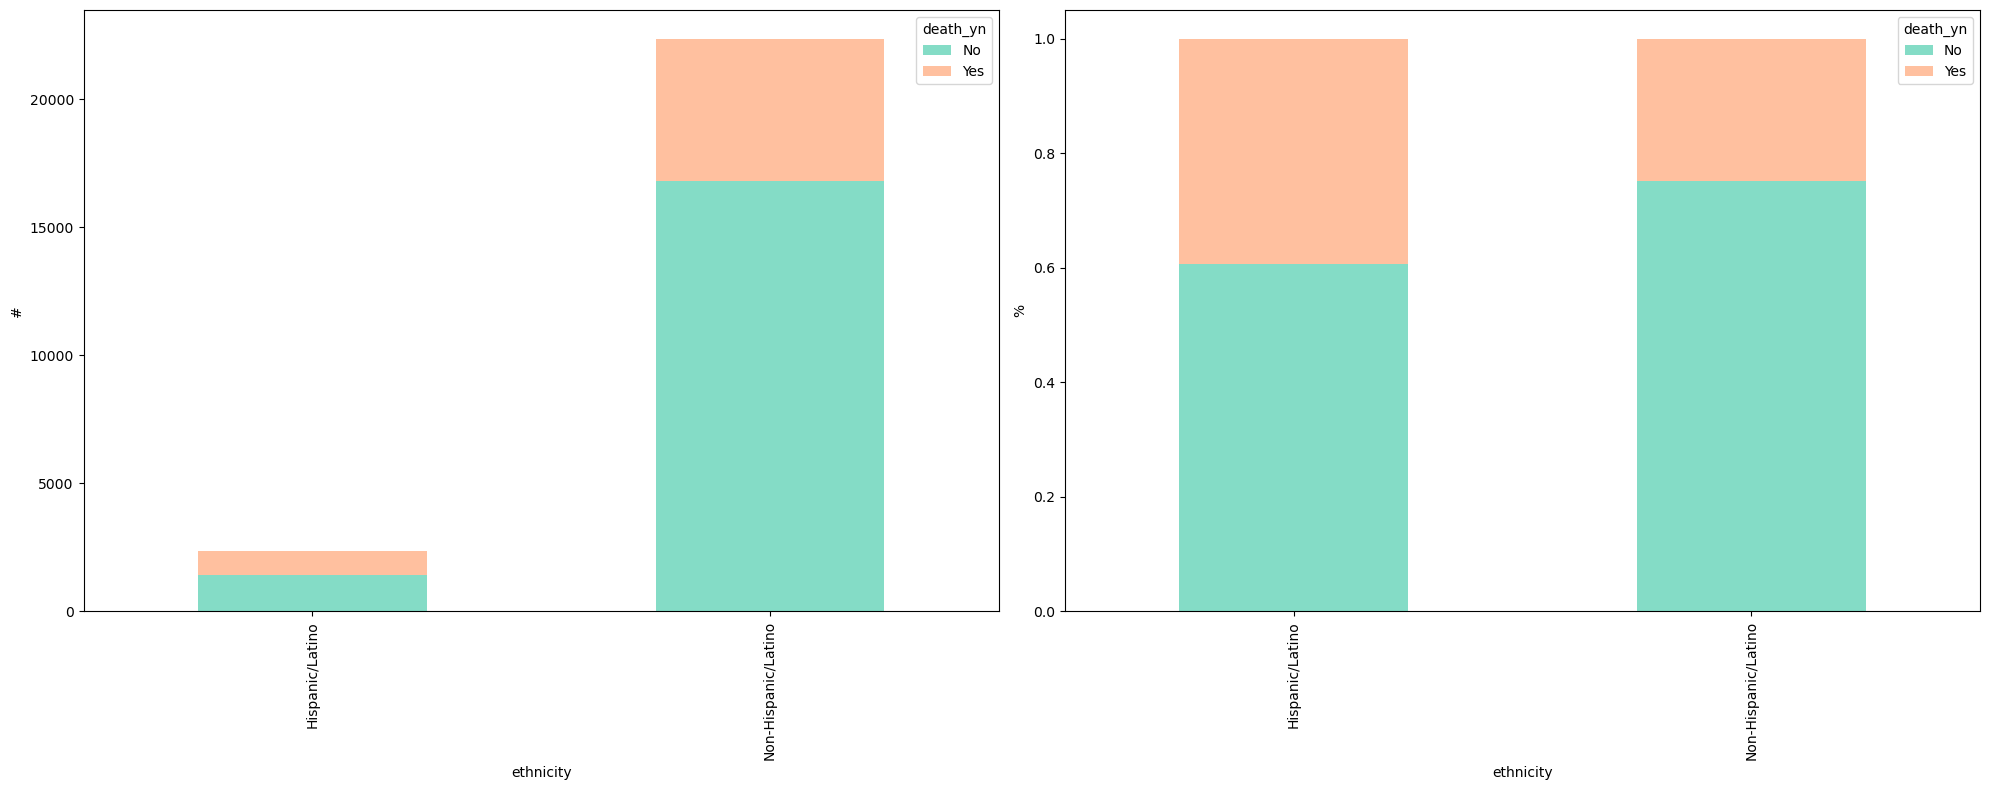

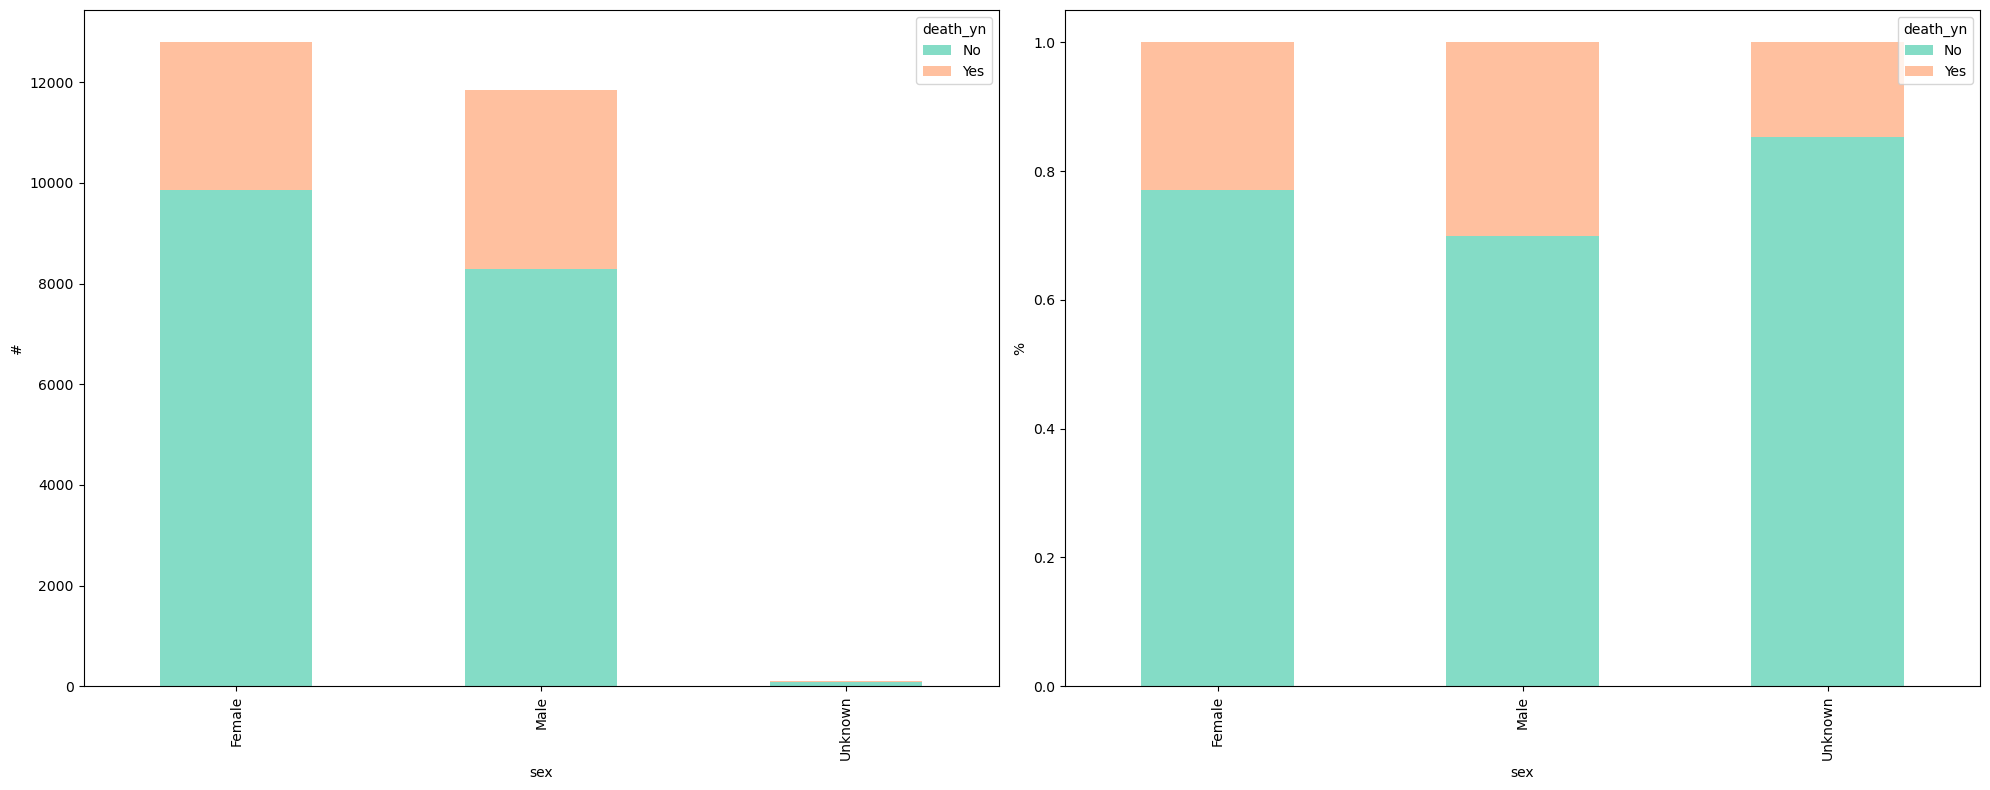

In [651]:

target_features = [train['race'], train['ethnicity'], train['sex']]
select_features = [train['death_yn']]

colours = ['#84dcc6', '#ffc09f']

for target_feature in target_features:

    for feature in select_features:

        fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
        train.groupby([target_feature, feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0], color=colours)
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
        axs[0].set_ylabel('#')

        train.groupby([target_feature, feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1], color=colours)
        axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
        axs[1].set_ylabel('%')
        
        plt.tight_layout()
        plt.show()

## Observations:

1. As the COVID19 pandemic progressed, we can generally observe both a reduction in the number of deaths per month and the proporption of deaths with regards the whole, month-on-month. The outlier here is January 2022. From the CDC dataset provided, we cannot discern whether or not the patient was vaccinated, however we can use the months here as a proxy for the Vaccine rollout program in the US, which began mid-December 2020 and had more or less concluded by the end of the following year. The death ratio falling against total cases broadly follows the vaccination rollout scheme, despite this information not formally recorded in our dataset. Anecdotally, as COVID19 pandemic persisted more and more COVID mutations occured, often leading the new dominant COVID virus to be more transmissible at the expense of its lethality.

2. The data also suggests that age is a predominant and robust factor when gauging the impact contracting COVID will have on your health. Our data shows that those who belong to the oldest age bracket (65+) and test positive for COVID are far more likely to die than those who are younger (compare 65+ against 0-17 years old). Our data also shows that those who are older are more exposed to the risk of COVID, in that the oldest age bucket leads in terms of hospitalisations, ICU admissions, and underlying conditions in comparison to the other age brackets. This aligns with what is now known about COVID-19, that older adults and those with underlying health conditions are considered to be at a higher risk of severe illness and death from COVID-19. 

3. The data also demonstrates that having underlying medical conditions increases the risk of hospitalisation, ICU admission, and death from COVID-19. And while we do not get access to the comorbidities affecting the patients in our dataset, those who reported as having underlying conditions such as diabtes, hypertension, obesity (etc.), confer a much higher risk of death from COVID-19 than others.

4. The data also shows that in the event of being admitted to hospital or the ICU, the success of making a full recovery is limited, and drasticly decreases the older you are. The data also proves the opposite whereby the younger you are the more resilient you are to COVID, leading to far fewer hospitalisation, admissions to ICU, and deaths. 

5. The data also shows that minorities, categorised in our race and ethnicity features (Black, Hispanic, Asian), are hospitalised, admitted to ICU, and die more regularly than their white counterparts pro rata. Without more granular information on our patient it is hard to say exactly what factors are driving these disparities: access to healthcare; wealth; etc.,

6. The dataset also shows that there is a gender discrepancy in COVID-19 cases, with females accounting for a higher proportion of cases than males. However, this trend is reversed for hospitalisations, ICU admissions, and deaths, where males are more likely to be affected.

7. It is also difficult to surmise from our dataset the impact of locality has on a given patient's likelihood to survive. While the data shows that certain states have higher rates of hospitalisations, ICU admissions, and deaths given the absence of other qualifying datapoints (population density, hospitals in given county, bed-availabilty etc.,) it is quite difficult to gauge the impact a given county or state has on a patient, despite what you might first assume.

8. Our dataset also shows that those who knew that they had been exposed to COVID fared better in terms of hospitalisations, ICU admissions, and deaths than in comparison to those we were unsure. 

9. The data also demonstrates that there is a weak correlation between case_onset_intervals and case_positive_specimen_intervals, with the correlation coefficient is close to zero. This indicates that the timing of when a person experiences symptoms (case onset interval) and when they test positive for COVID-19 (case positive specimen interval) are not strongly associated with each other.

10. Our data also shows that there is a weak positive correlation between our continuous features, and when we map these continuous features against our target feature, there is no real discernible pattern that diffrentiates yes from no. For this reason we are not going to pursue this feature for our future modelss


## Selected Features

Based on the above observations, the subset of features we are going to use to model the health profile of our patients are: 

i. <b>Age Group</b>, 
ii. <b>Case Month</b>, 
iii. <b>Hospitalisation Status</b>, 
iv. <b>ICU Status</b>, 
v. <b>Underlying Conditions</b>. 

Let's transform these features into new features with discrete values so we can use them in our models.

#### Case Month

In [652]:
month_map = {'2020-01': 0, 
             '2020-02': 1, 
             '2020-03': 2, 
             '2020-04': 3,
             '2020-05': 4,
             '2020-06': 5,
             '2020-07': 6,
             '2020-08': 7,
             '2020-09': 8,
             '2020-10': 9,
             '2020-11': 10,
             '2020-12': 11,
             '2021-01': 12,
             '2021-02': 13,
             '2021-03': 14,
             '2021-04': 15,
             '2021-05': 16,
             '2021-06': 17,
             '2021-07': 18,
             '2021-08': 19,
             '2021-09': 20,
             '2021-10': 21,
             '2021-11': 22,
             '2021-12': 23,
             '2022-01': 24,
             '2022-02': 25,
             '2022-03': 26,
             '2022-04': 27,
             '2022-05': 28,
             '2022-06': 29,
             '2022-07': 30,
             '2022-08': 31,
             '2022-09': 32,
             '2022-10': 33,
             '2022-11': 34
             }

train['case_month'] = train['case_month'].map(month_map)
test['case_month'] = test['case_month'].map(month_map)

#### Age Group

In [653]:
age_map = {'0 - 17 years': 0, 
           '18 to 49 years': 1, 
           '50 to 64 years': 2, 
           '65+ years': 3
           }

train['age_group'] = train['age_group'].map(age_map)
test['age_group'] = test['age_group'].map(age_map)

#### Hospitalisation 

In [654]:
hosp_map = { 'Unknown': 0, 
            'Yes': 1, 
            }

train['hosp_yn'] = train['hosp_yn'].map(hosp_map)
test['hosp_yn'] = test['hosp_yn'].map(hosp_map)

#### ICU 

In [655]:
icu_map = {'Unknown': 0, 
            'Yes': 1, 
            }

train['icu_yn'] = train['icu_yn'].map(icu_map)
test['icu_yn'] = test['icu_yn'].map(icu_map)

### Exposure

In [656]:
exposure_map = {'Unknown': 0, 
            'Yes': 1, 
            }

train['exposure_yn'] = train['exposure_yn'].map(icu_map)
test['exposure_yn'] = test['exposure_yn'].map(icu_map)

#### Underlying Conditions

In [657]:
underlying_map = {'Unknown': 0, 
                  'Yes': 1, 
                }

train['underlying_conditions_yn'] = train['underlying_conditions_yn'].map(underlying_map)
test['underlying_conditions_yn'] = test['underlying_conditions_yn'].map(underlying_map)

In [658]:
# train['definite_underlying'] = (train['underlying_conditions_yn'] == 1).astype(int)
# train['uncertain_underlying'] = (train['underlying_conditions_yn'] == 0).astype(int)

# test['definite_underlying'] = (test['underlying_conditions_yn'] == 1).astype(int)
# test['uncertain_underlying'] = (test['underlying_conditions_yn'] == 0).astype(int)

#### Death

In [659]:
death_map = {'No': 0,
             'Yes': 1,
             }

train['death_yn'] = train['death_yn'].map(death_map)
test['death_yn'] = test['death_yn'].map(death_map)

# Task 2: Predictive Modeling - Linear Regression

The aim of this task is to perform some basic predictive analysis on the data prepared in task one. To this end, a linear regression model will be created using the training data yielded by the train-test split from the previous task. The features to be analyzed in this section are:

i. <b>age</b>, 
ii. <b>case month</b>, 
iii. <b>hospilisation status</b>, 
iv. <b>ICU status</b>, 
v. <b>underlying conditions</b>. 

## 2.1 Training our Linear Regression Model

Here we train our linear regression model based on the features we selected above. We train this model against our target feature which is death.

In [660]:
linear_regression_x_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
linear_regression_y_train = train['death_yn']

linear_regression_x_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
linear_regression_y_test = test['death_yn']

Sanity checking feature selection for model

In [661]:
print(linear_regression_x_train.shape)
print(linear_regression_x_test.shape)

(24743, 5)
(10605, 5)


In [662]:
lr = LinearRegression()
lr.fit(linear_regression_x_train, linear_regression_y_train)
linear_regression_y_pred = lr.predict(linear_regression_x_train)

## 2.2 Evaluating the Coefficients of our Linear Regression Model

Here we print the coefficients of each feature we used to train the model

In [663]:
lr_coeff = pd.DataFrame({'Feature': linear_regression_x_train.columns, 'Coeff': lr.coef_})
lr_coeff.reset_index(drop=True, inplace=True)
lr_coeff

,Feature,Coeff
0,case_month,-0.006725
1,age_group,0.194649
2,hosp_yn,0.422930
3,icu_yn,0.137153
4,underlying_conditions_yn,-0.055488


### Observations:

1. <b>Case Month</b>: The coefficient for Case Month is -0.006671, which indicates that there is a small negative correlation between the month of the reported case and the target variable. That is to say that as the month of the reported case increases, the value of the target variable is expected to decrease slightly. This makes sense as we can understand time here to be a proxy (of sorts) for vaccination and the decreasing lethality of COVID19 as it mutated over the course of 34 months.

2. <b>Age Group</b>: The coefficient for this feature is 0.198640, which indicates a positive correlation between the age group and the target variable. In other words, as the age group of the patient increases, the value of the target variable is expected to increase. This follows the trends we observe from our dataset where the older the patient the more likely they are of dying from COVID19.

3. <b>Hospitlisation Status</b>: This feature represents whether the patient was hospitalised for COVID19 or not. As we might expect, the coefficient for this feature is relatively high at 0.413565, which demonstrates a strong positive correlation between hospitalisation and the target variable, death. 

4. <b> ICU Status </b>: Represents whether the patient was admitted to the ICU or not. The coefficient for this feature is 0.147415, which indicates a relatively strong positive correlation between ICU admission and our target variable, but not as strong as hospitalisation. However, we can understand this feature as a subset of hospilisation, as 99.8% of our patients who were admitted to ICU were first hospitalised, which in part can help us understand why this value is weighted less than hospitalisation.

5. <b> Underlying Health Conditions </b>: The coefficient for this feature is confusing at the model infers a negative correlation to having underlying health conditions. This finding is counterintuitive, as individuals with underlying health conditions are often thought to be at higher risk for adverse outcomes such as hospitalisation or death from COVID-19. However, it is important to remember that the coefficient represents the association between the predictor variable and the target outcome after accounting for the effects of other predictor variables in the model. In this case, it is possible that other predictor variables, such as age or hospitalisation status, may be more strongly associated with the target outcome than underlying health condition, and that the effect of underlying health condition on the target outcome is actually negative when these other factors are taken into account. Therefore, the negative coefficient for "definite_underlying" suggests that the presence of a definite underlying health condition alone may not be a strong predictor of the target outcome in this model.

## 2.3.1 Target Value and Class Prediction

Here we print the predicted target feature value for the first 10 training examples, and the predicted class for the first 10 training examples.

In [664]:
# predict target feature values for first 10 training examples
linear_regression_y_train_pred_10 = lr.predict(linear_regression_x_train[:10])
y_train_pred_df = pd.DataFrame({'Predicted target feature values': linear_regression_y_train_pred_10})

# threshold predicted target feature values to get predicted classes
linear_regression_y_train_pred_class_10 = (lr.predict(linear_regression_x_train[:10]) > 0.5).astype(int)
y_train_pred_df['Predicted class'] = linear_regression_y_train_pred_class_10

print(y_train_pred_df)

   Predicted target feature values  Predicted class
0                         0.921902                1
1                         0.962251                1
2                         0.096224                0
3                         0.478798                0
4                         0.015527                0
5                         0.297598                0
6                         0.371203                0
7                         0.042426                0
8                         0.136572                0
9                         0.485530                0


## 2.3.2 Classification Evaluation Measures on Training Set

Below we print the classification evaluation measures computed on the full training set.

In [665]:
# evaluate model on full training set
linear_regression_y_train_pred = lr.predict(linear_regression_x_train)

linear_regression_y_train_pred_class = (linear_regression_y_train_pred > 0.5).astype(int)

linear_regression_accuracy_train = accuracy_score(linear_regression_y_train, linear_regression_y_train_pred_class)
linear_regression_precision_train = precision_score(linear_regression_y_train, linear_regression_y_train_pred_class)
linear_regression_recall_train = recall_score(linear_regression_y_train, linear_regression_y_train_pred_class)
linear_regression_f1_train = f1_score(linear_regression_y_train, linear_regression_y_train_pred_class)

linear_regression_confusion_train = confusion_matrix(linear_regression_y_train, linear_regression_y_train_pred_class)

linear_regression_mse_train = mean_squared_error(linear_regression_y_train, linear_regression_y_train_pred_class)
linear_regression_mae_train = mean_absolute_error(linear_regression_y_train, linear_regression_y_train_pred_class)
linear_regression_rmse_train = np.sqrt(linear_regression_mse_train)
linear_regression_r2_train = r2_score(linear_regression_y_train, linear_regression_y_train_pred_class)

print("\nEvaluation metrics on the training set:")
print()
print("Accuracy: {:.2f}".format(linear_regression_accuracy_train))
print("Precision: {:.2f}".format(linear_regression_precision_train))
print("Recall: {:.2f}".format(linear_regression_recall_train))
print("F1 score: {:.2f}".format(linear_regression_f1_train))
print()
print("Confusion matrix:\n", linear_regression_confusion_train)
print()
# print("Mean Squared Error: {:.2f}".format(linear_regression_mse_train))
# print("Mean Absolute Error: {:.2f}".format(linear_regression_mae_train))
# print("R^2: {:.2f}".format(linear_regression_r2_train))
# print("Root Mean Squared Error: {:.2f}".format(linear_regression_rmse_train))


Evaluation metrics on the training set:

Accuracy: 0.88
Precision: 0.87
Recall: 0.65
F1 score: 0.75

Confusion matrix:
 [[17585   649]
 [ 2251  4258]]



In [666]:
# Calculate the total number of instances
total_instances = np.sum(linear_regression_confusion_train)
linear_regression_confusion_train_percentage = (linear_regression_confusion_train / total_instances) * 100
print("Confusion matrix as a percentage:\n", linear_regression_confusion_train_percentage)

Confusion matrix as a percentage:
 [[71.07060583  2.62296407]
 [ 9.09752253 17.20890757]]


Adding all of our performance metrics to an iterable so we can loop over them for graph generation later

In [667]:
list_of_linear_regression_training_stats = [linear_regression_accuracy_train, linear_regression_precision_train, linear_regression_recall_train, linear_regression_f1_train, linear_regression_mse_train, linear_regression_mae_train, linear_regression_rmse_train, linear_regression_r2_train]

In [668]:
print("Linear Regression Classification Report:\n", classification_report(linear_regression_y_train, linear_regression_y_train_pred_class))

Linear Regression Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92     18234
           1       0.87      0.65      0.75      6509

    accuracy                           0.88     24743
   macro avg       0.88      0.81      0.83     24743
weighted avg       0.88      0.88      0.88     24743



## Observations:

Based on the provided evaluation metrics, the model seems to quite well on our training set. 

1. The <b>Accuracy</b> of 0.88 indicates that the model predicted correctly 88% of the time. 
2. <b>Precision</b> is a measure of how many of the instances that the model predicted as positive were actually positive. A precision score of 0.87 means that out of all the instances that the model predicted as positive, 87% of the time the instance was actually positive.
3. For <b>Recall</b> we measured quite poorly, all things considered. A recall score of 0.65 means that the model correctly identified 65% of all the actual positive instances.
4. The <b>F1 Score</b> of 0.75 is a harmonic mean of precision and recall, which is a useful metric when there is an imbalance in the number of instances of each class. In this case, the F1 score indicates a good balance between precision and recall.
5. Our <b>Confusion Matrix</b> is a visualisation of the distribution of correct and incorrect predictions across the two classes in table format:

    1. True Negatives (TN): 17585 - These are the cases where the model correctly predicts that a patient did not die (i.e., the actual outcome is negative, and the model predicts negative). In material terms, this means identifying patients who survived.

    2. False Positives (FP): 649 - These are the cases where the model incorrectly predicts that a patient died (i.e., the actual outcome is negative, but the model predicts positive). In material terms, this means falsely identifying patients as deceased when they actually survived.

    3. False Negatives (FN): 2251 - These are the cases where the model incorrectly predicts that a patient did not die (i.e., the actual outcome is positive, but the model predicts negative). In material terms, this means failing to identify patients who actually died.

    4. True Positives (TP): 4258 - These are the cases where the model correctly predicts that a patient died (i.e., the actual outcome is positive, and the model predicts positive). In material terms, this means accurately identifying patients who died.

## 2.4.1 Classification Evaluation Comparison Between Training and Testing Sets

In [669]:
#Evaluate model on full test set
linear_regression_y_test_pred = lr.predict(linear_regression_x_test)

linear_regression_y_test_pred_class = (linear_regression_y_test_pred > 0.5).astype(int)

linear_regression_accuracy_test = accuracy_score(linear_regression_y_test, linear_regression_y_test_pred_class)
linear_regression_precision_test = precision_score(linear_regression_y_test, linear_regression_y_test_pred_class)
linear_regression_recall_test = recall_score(linear_regression_y_test, linear_regression_y_test_pred_class)
linear_regression_f1_test = f1_score(linear_regression_y_test, linear_regression_y_test_pred_class)

linear_regression_confusion_test = confusion_matrix(linear_regression_y_test, linear_regression_y_test_pred_class)

linear_regression_mae_test = mean_absolute_error(linear_regression_y_test, linear_regression_y_test_pred_class)
linear_regression_mse_test = mean_squared_error(linear_regression_y_test, linear_regression_y_test_pred_class)
linear_regression_rmse_test = np.sqrt(linear_regression_mse_test)
linear_regression_r2_test = r2_score(linear_regression_y_test, linear_regression_y_test_pred_class)

print("\nEvaluation metrics on the test set:")
print("Accuracy: {:.2f}".format(linear_regression_accuracy_test))
print("Precision: {:.2f}".format(linear_regression_precision_test))
print("Recall: {:.2f}".format(linear_regression_recall_test))
print("F1 score: {:.2f}".format(linear_regression_f1_test))
print()
print("Confusion matrix:\n", linear_regression_confusion_test)
print()
# print("Mean Squared Error: {:.2f}".format(linear_regression_mse_test))
# print("Mean Absolute Error: {:.2f}".format(linear_regression_mae_train))
# print("R^2: {:.2f}".format(linear_regression_r2_test))
# print("Root Mean Squared Error: {:.2f}".format(linear_regression_rmse_test))

list_of_linear_regression_testing_stats = [linear_regression_accuracy_test, linear_regression_precision_test, linear_regression_recall_test, linear_regression_f1_test,linear_regression_mse_test, linear_regression_mae_test, linear_regression_rmse_test, linear_regression_r2_test]


Evaluation metrics on the test set:
Accuracy: 0.88
Precision: 0.86
Recall: 0.64
F1 score: 0.74

Confusion matrix:
 [[7524  282]
 [1006 1793]]



In [670]:
print("Classification Report:\n", classification_report(linear_regression_y_test, linear_regression_y_test_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      7806
           1       0.86      0.64      0.74      2799

    accuracy                           0.88     10605
   macro avg       0.87      0.80      0.83     10605
weighted avg       0.88      0.88      0.87     10605



In [671]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE', 'RMSE', 'R2']

for i in range(len(metrics)):
    print(metrics[i])
    print('='*30)
    print('Trained Data: ', list_of_linear_regression_training_stats[i])
    print('Tested Data: ', list_of_linear_regression_testing_stats[i])
    print()

Accuracy
Trained Data:  0.8827951339772865
Tested Data:  0.8785478547854786

Precision
Trained Data:  0.8677399633177094
Tested Data:  0.8640963855421687

Recall
Trained Data:  0.6541711476417268
Tested Data:  0.6405859235441229

F1 Score
Trained Data:  0.7459705676243868
Tested Data:  0.735740664751744

MSE
Trained Data:  0.11720486602271349
Tested Data:  0.12145214521452145

MAE
Trained Data:  0.11720486602271349
Tested Data:  0.12145214521452145

RMSE
Trained Data:  0.3423519622007642
Tested Data:  0.3484998496621217

R2
Trained Data:  0.39541950613415633
Tested Data:  0.3748343745254359



As might be expected, the model performance on the training data and test data was incredibly similar. Both confusion matrices performed well on predicting negatives, but performed slightly worse when detecting positives. Metrics like accuracy, presicion, F1, and MSE proved identical, with only minor differences in Recall and R^2 to the tune of .01. 

Overall, performance on both the testing and training data seems to indicate a model with generally high accuracy, and precision, reacall, and F1 scores in excess of 90%. This kind of performance bodes well for a linear regression model's potential as a best fit for this particular problem.

## 2.4.2 K-Fold Cross Validation

In [672]:
#performing 5 fold K-fold cross validation on linear regression model using full dataset

#concatenating train and test datasets for independent and dependent variables
X = pd.concat([train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']], 
                                 test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]])
y = pd.concat([train['death_yn'], test['death_yn']]) 

#folds for cross validation
folds = 5

#creating K-Fold object
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

#K-fold cross validation scores
mse_scores = -cross_val_score(lr, X, y, cv=folds, scoring="neg_mean_squared_error")

#printing results
print(f"MSE scores: {mse_scores}")

MSE scores: [0.07654521 0.08365743 0.08022474 0.0826922  0.07882927]


The MSE scores produced by the K-Fold cross valdation process performed on the linear regression model were generally very low, with none exceeding 0.083. This indicates that the linear regression implementation is relatively sucessful and predicting the dependent outcome based on the provided independent features, even when performed on subsets of the full dataset. This is consistent with the relatively high accuracy yielded by the model when performing analysis of the testing and training data. Taken together, the model performance information and the K-fold cross validation information give us a good indication that this model would likely perform well on new data.

# Task 3: Predictive Modeling - Logistic Regression

The aim of this task is to perform some basic predictive analysis on the data prepared in task one. To this end, a logistic regression model will be created using the training data yielded by the train-test split from the previous task. The features to be analyzed in this section are:

i. <b>age</b>, 
ii. <b>case month</b>, 
iii. <b>hospilisation status</b>, 
iv. <b>ICU status</b>, 
v. <b>underlying conditions</b>. 

## 3.1 Training our Logistic Regression Model

Here we train our logistic regression model based on the features we selected above. We train this model against our target feature which is death.

In [673]:
logistic_regression_x_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
logistic_regression_y_train = train['death_yn']

logistic_regression_x_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
logistic_regression_y_test = test['death_yn']

In [674]:
logr = LogisticRegression()
logr.fit(logistic_regression_x_train, logistic_regression_y_train)
logistic_regression_y_pred = logr.predict(logistic_regression_x_train)

Sanity checking feature selection for model

In [675]:
print(logistic_regression_x_train.shape)
print(logistic_regression_x_test.shape)

(24743, 5)
(10605, 5)


## 3.2 Evaluating the Coefficients of our Logistic Regression Model

Here we print the coefficients of each feature we used to train the model

In [676]:
logr_coeff = pd.DataFrame({'Feature': logistic_regression_x_train.columns, 'Coeff': logr.coef_.ravel()})
logr_coeff.reset_index(drop=True, inplace=True)
logr_coeff

,Feature,Coeff
0,case_month,-0.084195
1,age_group,2.588495
2,hosp_yn,2.507139
3,icu_yn,2.322572
4,underlying_conditions_yn,-0.647534


## Observations:

1. Similar to our Linear Regression model, the negative coefficient of -0.084 indicates that there is an inverse relationship between <b>Case Month</b> and the positive class probability. That is to say that when the case month increases, the log-odds of the positive class decreases. This again complements our initial observations that case month is a fair proxy for baseline vaccination percentages across the american population and the decreasing lethality of the COVID19 pathogen.
2. Again similar to our Linear Regression Model, the Logistic Regression Model weights <b>Age Group</b> quite heavilty. The positive coefficient 2.588 indicates that as the age of our patient increases, the log-odds of the positive class also increase. This means there is a direct relationship between the age of our patient andthe positive class probability. Suffice it to say that older patients are more likely to die than younger patients of COVID.
3. The Logistic Regression Model also weights <b>Hospilisation Status</b> and <b>ICU Status</b> quite highly, with coefficients of 2.507 and 2.322 respectively. This infers that when a patient is hospitalised, or subsequently taken to the ICU after their hospitalisation, are more likely to die from COVID than those who have not rushed to hospital or been admitted to an ICU.
4. Again the cresults for <b>Underlying Conditions</b> seem to be rather counter-intuitive, as our Logistic Regression Model demonstrates that patients with underlying conditions are less likely to die than those without underlying conditions. This is reflected in the weak negative coefficient of -0.647. 





## 3.3.1 Target Value and Class Prediction

Here we print the predicted target feature value for the first 10 training examples, and the predicted class for the first 10 training examples.

In [677]:
logistic_regression_y_train_pred_10 = logr.predict_proba(logistic_regression_x_train)[:, 1][:10]
logistic_regression_y_train_pred_class_10 = (logr.predict(logistic_regression_x_train[:10]) >= 0.5).astype(int)

logistic_regression_output_df = pd.DataFrame({
    "Predicted Values": logistic_regression_y_train_pred_10,
    "Predicted Class": logistic_regression_y_train_pred_class_10
})

print(logistic_regression_output_df)

   Predicted Values  Predicted Class
0          0.964886                1
1          0.978513                1
2          0.010570                0
3          0.634993                1
4          0.003875                0
5          0.133958                0
6          0.311435                0
7          0.005418                0
8          0.017397                0
9          0.079224                0


## 3.3.2 Classification Evaluation Measures on Training Set

In [678]:
# predict target feature values for full training set
logistic_regression_y_train_pred = logr.predict_proba(logistic_regression_x_train)[:, 1]

# threshold predicted target feature values at 0.5 to get predicted class for full training set
logistic_regression_y_train_pred_class = (logistic_regression_y_train_pred >= 0.5).astype(int)

logistic_regression_accuracy_train = accuracy_score(logistic_regression_y_train, logistic_regression_y_train_pred_class)
logistic_regression_confusion_train = confusion_matrix(logistic_regression_y_train, logistic_regression_y_train_pred_class)
logistic_regression_recall_train = recall_score(logistic_regression_y_train, logistic_regression_y_train_pred_class)
logistic_regression_f1_train = f1_score(logistic_regression_y_train, logistic_regression_y_train_pred_class)

logistic_regression_precision_train = precision_score(logistic_regression_y_train, logistic_regression_y_train_pred_class)

logistic_regression_mae_train = mean_absolute_error(logistic_regression_y_train, logistic_regression_y_train_pred)
logistic_regression_mse_train = mean_squared_error(logistic_regression_y_train, logistic_regression_y_train_pred)
logistic_regression_rmse_train = np.sqrt(logistic_regression_mse_train)
logistic_regression_r2_train = r2_score(logistic_regression_y_train, logistic_regression_y_train_pred)

print("\nEvaluation metrics on the training set:")
print()
print("Accuracy: {:.2f}".format(logistic_regression_accuracy_train))
print("Precision: {:.2f}".format(logistic_regression_precision_train))
print("Recall: {:.2f}".format(logistic_regression_recall_train))
print("F1 score: {:.2f}".format(logistic_regression_f1_train))
print()
print("Confusion matrix:\n", logistic_regression_confusion_train)
print()
# print("Mean Squared Error: {:.2f}".format(logistic_regression_mse_train))
# print("Mean Absolute Error: {:.2f}".format(logistic_regression_mae_train))
# print("R2 score: {:.2f}".format(logistic_regression_r2_train))
# print("Root Mean Squared Error: {:.2f}".format(logistic_regression_rmse_train))


Evaluation metrics on the training set:

Accuracy: 0.90
Precision: 0.82
Recall: 0.81
F1 score: 0.82

Confusion matrix:
 [[17115  1119]
 [ 1261  5248]]



In [679]:
# Calculate the total number of instances
total_instances = np.sum(logistic_regression_confusion_train)
logistic_regression_confusion_train_percentage = (logistic_regression_confusion_train / total_instances) * 100
print("Confusion matrix as a percentage:\n", logistic_regression_confusion_train_percentage)

Confusion matrix as a percentage:
 [[69.17107869  4.52249121]
 [ 5.0963909  21.2100392 ]]


In [680]:
print("Classification Report:\n", classification_report(logistic_regression_y_train, logistic_regression_y_train_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93     18234
           1       0.82      0.81      0.82      6509

    accuracy                           0.90     24743
   macro avg       0.88      0.87      0.88     24743
weighted avg       0.90      0.90      0.90     24743



## Observations:

Based on the provided evaluation metrics, the model seems to quite well on our training set. 

1. The <b>Accuracy</b> of 0.90 indicates that the model predicted correctly 90% of the time. This score means that our model fared slightly better than our Linear Regression Model, but not by much. And while our model is more accurate, it is less accurate at predicting our target class than our Linear Regression Model.
2. A <b>Precision</b> score of 0.82 means that out of all the instances that the model predicted as positive, 82% of the time the instance was actually positive. And while our model is more accurate, it is less accurate at predicting our target class than our Linear Regression Model, which had a <b>Precision</b> score of 87%.
3. For <b>Recall</b> we fared better than our Linear Regression Model. A recall score of 0.81 is a significant improvement on our previous score of 0.65. This means that the model correctly identified 81% of all the actual positive instances.
4. The <b>F1 Score</b> of 0.82 is also a gain on our previous model.
5. Our <b>Confusion Matrix</b> is a visualisation of the distribution of correct and incorrect predictions across the both classes:

    1. True Negatives (TN): 17115 - These are the cases where the model correctly predicts that a patient did not die (i.e., the actual outcome is negative, and the model predicts negative). In material terms, this means identifying patients who survived.

    2. False Positives (FP): 1119 - These are the cases where the model incorrectly predicts that a patient died (i.e., the actual outcome is negative, but the model predicts positive). In material terms, this means falsely identifying patients as deceased when they actually survived.

    3. False Negatives (FN): 1261 - These are the cases where the model incorrectly predicts that a patient did not die (i.e., the actual outcome is positive, but the model predicts negative). In material terms, this means failing to identify patients who actually died.

    4. True Positives (TP): 5248 - These are the cases where the model correctly predicts that a patient died (i.e., the actual outcome is positive, and the model predicts positive). In material terms, this means accurately identifying patients who died.

Adding all of our performance metrics to an iterable so we can loop over them for graph generation later

In [681]:
list_of_logistic_regression_training_stats = [logistic_regression_accuracy_train, logistic_regression_precision_train, logistic_regression_recall_train, logistic_regression_f1_train, logistic_regression_mse_train, logistic_regression_mae_train, logistic_regression_rmse_train, logistic_regression_r2_train]

## 3.4.1: Classification Evaluation Comparison Between Training and Testing Sets

In [682]:
# Evaluate model on full test set
logistic_regression_y_test_pred = logr.predict_proba(logistic_regression_x_test)[:, 1]

# threshold predicted target feature values at 0.5 to get predicted class for full test set
logistic_regression_y_test_pred_class = (logistic_regression_y_test_pred >= 0.5).astype(int)

logistic_regression_accuracy_test = accuracy_score(logistic_regression_y_test, logistic_regression_y_test_pred_class)
logistic_regression_precision_test = precision_score(logistic_regression_y_test, logistic_regression_y_test_pred_class)
logistic_regression_recall_test = recall_score(logistic_regression_y_test, logistic_regression_y_test_pred_class)
logistic_regression_f1_test = f1_score(logistic_regression_y_test, logistic_regression_y_test_pred_class)

logistic_regression_confusion_test = confusion_matrix(logistic_regression_y_test, logistic_regression_y_test_pred_class)

logistic_regression_mae_test = mean_absolute_error(logistic_regression_y_test, logistic_regression_y_test_pred)
logistic_regression_mse_test = mean_squared_error(logistic_regression_y_test, logistic_regression_y_test_pred)
logistic_regression_rmse_test = np.sqrt(logistic_regression_mse_test)
logistic_regression_r2_test = r2_score(logistic_regression_y_test, logistic_regression_y_test_pred)

print("\nEvaluation metrics on the test set:")
print()
print("Accuracy: {:.2f}".format(logistic_regression_accuracy_test))
print("Precision: {:.2f}".format(logistic_regression_precision_test))
print("Recall: {:.2f}".format(logistic_regression_recall_test))
print("F1 score: {:.2f}".format(logistic_regression_f1_test))
print()
print("Confusion matrix:\n", logistic_regression_confusion_test)
print()
# print("Mean Absolute Error: {:.2f}".format(logistic_regression_mae_test))
# print("Mean Squared Error: {:.2f}".format(logistic_regression_mse_test))
# print("Root Mean Squared Error: {:.2f}".format(logistic_regression_rmse_test))
# print("R2 score: {:.2f}".format(logistic_regression_r2_test))

list_of_logistic_regression_testing_stats = [logistic_regression_accuracy_test, logistic_regression_precision_test, logistic_regression_recall_test, logistic_regression_f1_test,logistic_regression_mse_test, logistic_regression_mae_test, logistic_regression_rmse_test, logistic_regression_r2_test]


Evaluation metrics on the test set:

Accuracy: 0.90
Precision: 0.83
Recall: 0.79
F1 score: 0.81

Confusion matrix:
 [[7349  457]
 [ 576 2223]]



In [683]:
print("Classification Report:\n", classification_report(logistic_regression_y_test, logistic_regression_y_test_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      7806
           1       0.83      0.79      0.81      2799

    accuracy                           0.90     10605
   macro avg       0.88      0.87      0.87     10605
weighted avg       0.90      0.90      0.90     10605



In [684]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE', 'RMSE', 'R2']

for i in range(len(metrics)):
    print(metrics[i])
    print('='*30)
    print('Trained Data: ', list_of_logistic_regression_training_stats[i])
    print('Tested Data: ', list_of_logistic_regression_testing_stats[i])
    print()

Accuracy
Trained Data:  0.9038111789192903
Tested Data:  0.9025931164545026

Precision
Trained Data:  0.82425003926496
Tested Data:  0.8294776119402985

Recall
Trained Data:  0.8062682439698878
Tested Data:  0.7942122186495176

F1 Score
Trained Data:  0.8151599875737807
Tested Data:  0.8114619456105128

MSE
Trained Data:  0.06534586545947517
Tested Data:  0.0671219087222172

MAE
Trained Data:  0.131324632320077
Tested Data:  0.13290703486989328

RMSE
Trained Data:  0.25562837373710134
Tested Data:  0.2590789623304393

R2
Trained Data:  0.662924953952643
Tested Data:  0.654495110191316



Again, the performance of the logistic regression model between training and test data is quite similar. Accuracy and F1 score remain consistent, while precision and recall are again off by only .01. Performance on the confusion matrices are, again, very similar too. Overll, the metrics fromt he training and testing data indicate a well-performing model, at least on mpar with if not slightly superior to the linear regression model. This outcome might be expected with a logistic regression model, due to the binary nature of the dependent feature as well as several of the independent features.

In [685]:
#performing 5 fold K-fold cross validation on logistic regression model using full dataset

#concatenating train and test datasets for independent and dependent variables
X = pd.concat([train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']], 
                                 test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]])
y = pd.concat([train['death_yn'], test['death_yn']]) 

#folds for cross validation
folds = 5

#creating K-Fold object
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

#K-fold cross validation scores
mse_scores = -cross_val_score(logr, X, y, cv=folds, scoring="neg_mean_squared_error")

#printing results
print(f"MSE scores: {mse_scores}")

MSE scores: [0.08811881 0.0960396  0.10141443 0.10128731 0.09393125]


The MSE scores produced by the K-Fold cross validation process on the logistic regression model were again very low, with none exceeding 0.11. his indicates that the linear regression implementation is relatively sucessful and predicting the dependent outcome based on the provided independent features, even when performed on subsets of the full dataset. This is consistent with the relatively high accuracy yielded by the model when performing analysis of the testing and training data. Taken together, the model performance information and the K-fold cross validation information give us a good indication that this model would likely perform well on new data. 

One thing to note, however, is that the MSE scores produced were slightly lower than those of the linear regression model's cross validation data. This could indicate there the logistic regression model has some comparatively negative model performance, such as overfitting to certain parts of the data, or not performing as well on new data. Regardless, the accuracy remains high and the MSE scores remain low, indicating good model performance overall.

# Task 4: Predictive Modeling - Random Forest Classifier

The aim of this task is to perform some basic predictive analysis on the data prepared in task one. To achieve thi we are going to create a random forest classifer model. Again the features we are going to use to train this model are:

i. <b>age</b>, 
ii. <b>case month</b>, 
iii. <b>hospilisation status</b>, 
iv. <b>ICU status</b>, 
v. <b>underlying conditions</b>. 

 The model will then be evaluated based on its performance using the training data, the test data, and other linear regression models trained on the full dataset. 

## 4.1 Training our Random Forest Model

Here we train our random forest classifier model based on the features we selected above. We train this model against our target feature which is death.

In [686]:
random_forest_x_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
random_forest_y_train = train['death_yn']

random_forest_x_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
random_forest_y_test = test['death_yn']

In [687]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(random_forest_x_train, random_forest_y_train)
random_forest_y_pred = rfc.predict(random_forest_x_test)

## 4.2.1 How does Random Forest Work?

Random forest is an ensemble learning algorithm that creates multiple decision trees and then aggregates their results to make a final prediction. It works by creating a set of decision trees, where each tree is trained on a random subset of the data and a random subset of the features. During training, the algorithm chooses the best feature to split the data on, and then continues splitting until the data is fully separated, or a stopping criterion is met.

Once the decision trees are built, the algorithm aggregates their results to make a final prediction. As we are using a random forest classifier model, this is done by taking the mode of the predicted classes across all the trees.

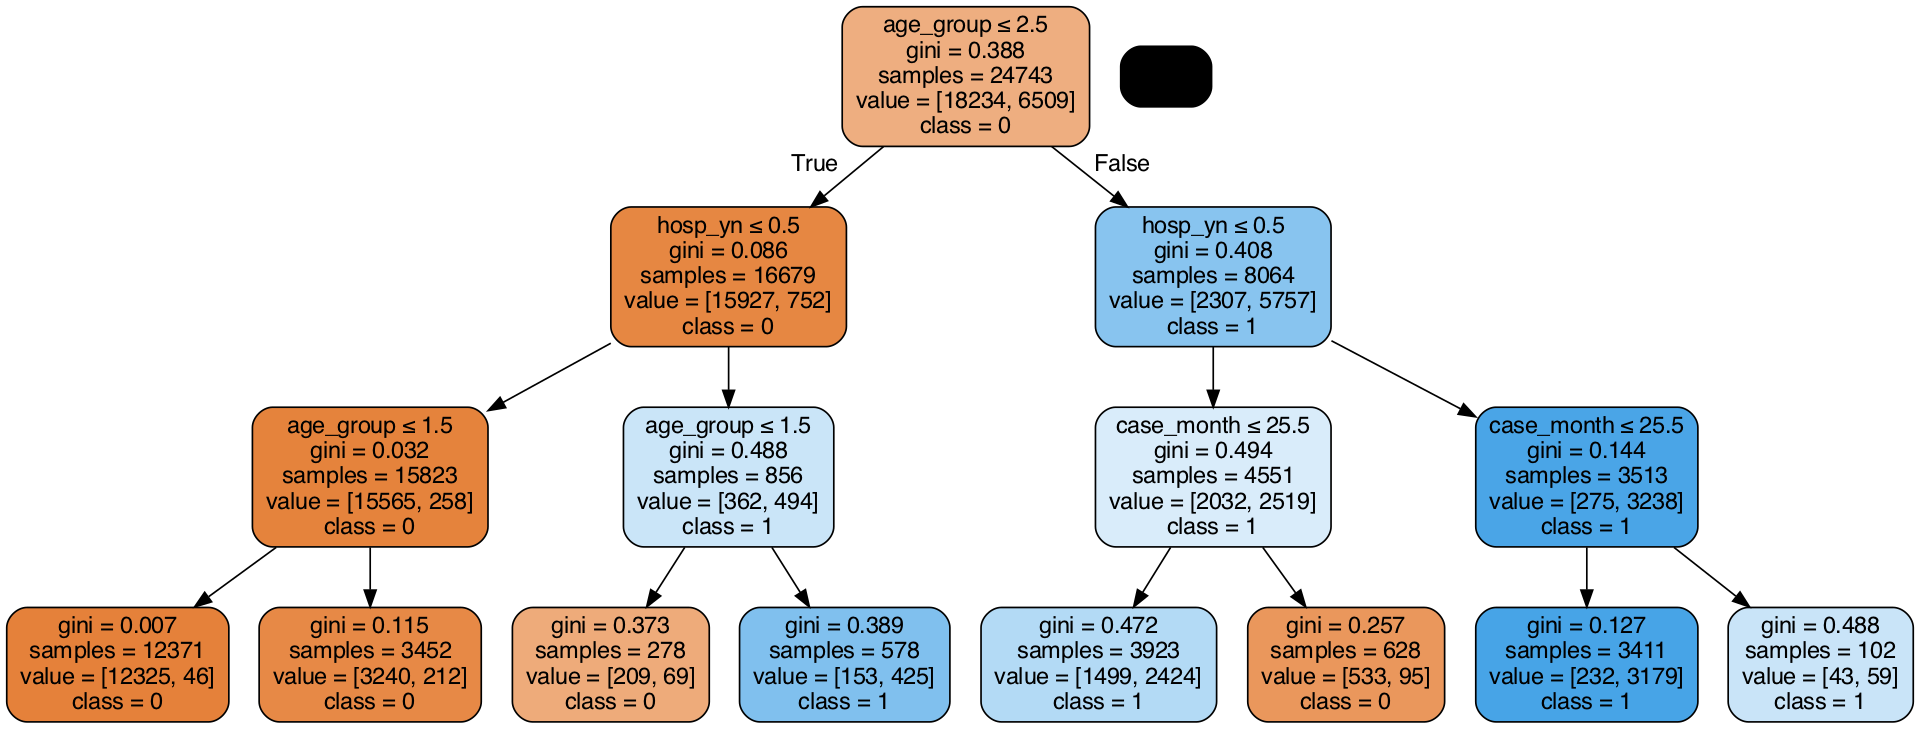

In [688]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
decision_tree.fit(random_forest_x_train, random_forest_y_train)

dot_data = export_graphviz(decision_tree, 
                           out_file=None, 
                           feature_names=random_forest_x_train.columns, 
                           class_names=['0', '1'],
                           filled=True, 
                           rounded=True, 
                           special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)

graph.set_size('"20,8!"')
Image(graph.create_png())

## 4.2.2 Evaluating the Feature Importance of our Random Forest Classifier Model


In [689]:
feature_importance = pd.DataFrame({'Feature': random_forest_x_train.columns, 'Significance':rfc.feature_importances_})
feature_importance.sort_values('Significance', ascending=False)

,Feature,Significance
1,age_group,0.537421
2,hosp_yn,0.302003
0,case_month,0.128465
3,icu_yn,0.028509
4,underlying_conditions_yn,0.003602


### Observations:

1. <b>Age Group here</b> leads the way in terms of feature importance, such that it is the dominant feature in terms of its contribution to the prediction model. It has an importance value of 0.537, which is significantly higher than the second most important feature, <b>hospitalisation Status</b>, with an importance value of 0.302. This matches our previous analysis where we observed that those who belonged to the oldest age bracket were the most exposed group to COVID, and resulted in the highest amount deaths.
2. <b>Hospitalisation Status</b> is our second most important feature and from previous analysis we have observed the high correlation between hospitlisation and the target feature. Here our models weights this feature quite heavily, which follows our previous observations and analysis; those who were admitted to hospital for COVID more than likely had a more serious case of COVID19 than those who were not admited to hospital. 
3. <b>Case Month</b> is weighted more highly here than it has been in other models. This is quite interesting, as earlier we posited that case month could potentially serve as  a proxy for COVID virus lethality (given the continuous evolution and mutation of the dominant COVID pathogen) and general vaccination rates (US vaccine program began in December 2020). While this is somewhat supposition, it is interesting that our model has picked up on this feature as being more imporant than both <b>ICU Status</b> and <b>Underlying Conditions</b>
4. Intersting that both <b>ICU Status</b> and <b>Underlying Conditions</b> were weighted quite lowly in this model. Again, this seems counter-intuitive as these are both important factors in determining the severity of COVID-19 cases. However, it's important to note that feature importance in a machine learning model is relative to the other features included in the model. So, while ICU status and underlying conditions may be important factors in determining the severity of COVID-19 cases, they may not be the most important factors in relation to the other features included in the model. It's also possible that the data used to train the model did not have a strong enough relationship between ICU status/underlying conditions and the target variable (severity) for these features to have a high weight in the model.

## 4.3.1

Here we print the predicted target feature value for the first 10 training examples, and the predicted class for the first 10 training examples.

In [690]:
random_forest_y_train_pred_10 = rfc.predict_proba(random_forest_x_train)[:, 1][:10]
random_forest_y_train_pred_class_10 = (rfc.predict(random_forest_x_train[:10]) > 0.5).astype(int)

random_forest_output_df = pd.DataFrame({
    "Predicted Values": random_forest_y_train_pred_10,
    "Predicted Class": random_forest_y_train_pred_class_10
})

print(random_forest_output_df)

   Predicted Values  Predicted Class
0          0.831217                1
1          0.970718                1
2          0.009406                0
3          0.666680                1
4          0.002221                0
5          0.047821                0
6          0.122431                0
7          0.017246                0
8          0.007208                0
9          0.000000                0


## 4.3.2 Classification Evaluation Measures on Training Set

Here we print a few classification evaluation measures computed on the full training set

In [691]:
# predict target feature values for full training set
random_forest_y_train_pred = rfc.predict_proba(random_forest_x_train)[:, 1]

# threshold predicted target feature values at 0.5 to get predicted class for full training set
random_forest_y_train_pred_class = (random_forest_y_train_pred >= 0.5).astype(int)

random_forest_accuracy_train = accuracy_score(random_forest_y_train, random_forest_y_train_pred_class)
random_forest_precision_train = precision_score(random_forest_y_train, random_forest_y_train_pred_class)
random_forest_recall_train = recall_score(random_forest_y_train, random_forest_y_train_pred_class)
random_forest_f1_train = f1_score(random_forest_y_train, random_forest_y_train_pred_class)

random_forest_confusion_train = confusion_matrix(random_forest_y_train, random_forest_y_train_pred_class)

random_forest_mae_train = mean_absolute_error(random_forest_y_train, random_forest_y_train_pred_class)
random_forest_mse_train = mean_squared_error(random_forest_y_train, random_forest_y_train_pred_class)
random_forest_rmse_train = np.sqrt(random_forest_mse_train)
random_forest_r2_train = r2_score(random_forest_y_train, random_forest_y_train_pred_class)

print("\nEvaluation metrics on the training set:")
print("Accuracy: {:.2f}".format(random_forest_accuracy_train))
print("Precision: {:.2f}".format(random_forest_precision_train))
print("Recall: {:.2f}".format(random_forest_recall_train))
print("F1 score: {:.2f}".format(random_forest_f1_train))
print()
print("Confusion matrix:\n", random_forest_confusion_train)
print()
# print("Mean Squared Error: {:.2f}".format(random_forest_mse_train))
# print("Mean Absolute Error: {:.2f}".format(random_forest_mae_train))
# print("R2 score: {:.2f}".format(random_forest_r2_train))
# print("Root Mean Squared Error: {:.2f}".format(random_forest_rmse_train))



Evaluation metrics on the training set:
Accuracy: 0.91
Precision: 0.80
Recall: 0.89
F1 score: 0.84

Confusion matrix:
 [[16802  1432]
 [  704  5805]]



In [692]:
# Calculate the total number of instances
total_instances = np.sum(random_forest_confusion_train)
random_forest_confusion_train_percentage = (random_forest_confusion_train / total_instances) * 100
print("Confusion matrix as a percentage:\n", random_forest_confusion_train_percentage)

Confusion matrix as a percentage:
 [[67.90607445  5.78749545]
 [ 2.84524916 23.46118094]]


Again, adding our performance metrics to an iterable so we can loop over them.

In [693]:
list_of_random_forest_training_stats = [random_forest_accuracy_train, random_forest_precision_train, random_forest_recall_train, random_forest_f1_train,random_forest_mse_train, random_forest_mae_train, random_forest_rmse_train, random_forest_r2_train]

### Observations:

Based on the provided evaluation metrics, the model seems to perform well on the training set. 

1. The <b>accuracy</b> of 0.91 indicates that the model predicted correctly 91% of the time. 
2. <b>Precision</b> is a measure of how many of the instances that the model predicted as positive were actually positive. In other words, it measures how many true positives the model predicted out of all the instances it predicted as positive. A precision score of 0.81 means that out of all the instances that the model predicted as positive, only 81% of them were actually positive.
3. <b>Recall</b> is a measure of how many of the actual positive instances the model correctly identified. In other words, it measures how many true positives the model predicted out of all the actual positive instances. A recall score of 0.89 means that the model correctly identified 89% of all the actual positive instances.
4. The <b>F1 Score</b> of 0.84 is a harmonic mean of precision and recall, which is a useful metric when there is an imbalance in the number of instances of each class. In this case, the F1 score indicates a good balance between precision and recall.
5. Our <b>Confusion Matrix</b> is a visualisation of the distribution of correct and incorrect predictions across the two classes in table format:

    1. True Negatives (TN): 16802 - These are the cases where the model correctly predicts that a patient did not die (i.e., the actual outcome is negative, and the model predicts negative). In material terms, this means identifying patients who survived.

    2. False Positives (FP): 1432 - These are the cases where the model incorrectly predicts that a patient died (i.e., the actual outcome is negative, but the model predicts positive). In material terms, this means falsely identifying patients as deceased when they actually survived.

    3. False Negatives (FN): 704 - These are the cases where the model incorrectly predicts that a patient did not die (i.e., the actual outcome is positive, but the model predicts negative). In material terms, this means failing to identify patients who actually died.

    4. True Positives (TP): 5805 - These are the cases where the model correctly predicts that a patient died (i.e., the actual outcome is positive, and the model predicts positive). In material terms, this means accurately identifying patients who died.


In [694]:
print("Random Forest Classifier Classification Report:\n", classification_report(random_forest_y_train, random_forest_y_train_pred_class))

Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     18234
           1       0.80      0.89      0.84      6509

    accuracy                           0.91     24743
   macro avg       0.88      0.91      0.89     24743
weighted avg       0.92      0.91      0.92     24743



From the classification report, we can see that our model is more comfortable in predicting the negative class with a precision of 0.96 and a recall of 0.92. This means that among all the instances that the model predicted as negative, 96% of them were actually negative and the model correctly identified 92% of all actual negative instances.

However, our random forest classifier  model is less comfortable in predicting the positive class (class 1) with a precision of 0.81 and a recall of 0.89. Only 81% of them were actually positive and the model correctly identified 89% of all actual positive instances. 

In comparison with the other models, despite the random forest classifier's higher overall accuracy, it has a lower accuracy than linear regression and logistic regression when attempting to predict the positive class. As this is our priority we should always bear this in mind when evalutating the performance of our models.

## 4.4.1: Classification Evaluation Comparison Between Training and Testing Sets

In [695]:
# predict target feature values for full testing set
random_forest_y_test_pred = rfc.predict_proba(random_forest_x_test)[:, 1]

# threshold predicted target feature values at 0.5 to get predicted class for full testing set
random_forest_y_test_pred_class = (random_forest_y_test_pred >= 0.5).astype(int)

random_forest_accuracy_test = accuracy_score(random_forest_y_test, random_forest_y_test_pred_class)
random_forest_precision_test = precision_score(random_forest_y_test, random_forest_y_test_pred_class)
random_forest_recall_test = recall_score(random_forest_y_test, random_forest_y_test_pred_class)
random_forest_f1_test = f1_score(random_forest_y_test, random_forest_y_test_pred_class)

random_forest_confusion_test = confusion_matrix(random_forest_y_test, random_forest_y_test_pred_class)

random_forest_mae_test = mean_absolute_error(random_forest_y_test, random_forest_y_test_pred_class)
random_forest_mse_test = mean_squared_error(random_forest_y_test, random_forest_y_test_pred_class)
random_forest_rmse_test = np.sqrt(random_forest_mse_test)
random_forest_r2_test = r2_score(random_forest_y_test, random_forest_y_test_pred_class)

print("\nEvaluation metrics on the testing set:")
print()
print("Accuracy: {:.2f}".format(random_forest_accuracy_test))
print("Precision: {:.2f}".format(random_forest_precision_test))
print("Recall: {:.2f}".format(random_forest_recall_test))
print("F1 score: {:.2f}".format(random_forest_f1_test))
print()
print("Confusion matrix:\n", random_forest_confusion_test)
print()
# print("Mean Squared Error: {:.2f}".format(random_forest_mse_test))
# print("Mean Absolute Error: {:.2f}".format(random_forest_mae_test))
# print("R2 score: {:.2f}".format(random_forest_r2_test))
# print("Root Mean Squared Error: {:.2f}".format(random_forest_rmse_test))

list_of_random_forest_testing_stats = [random_forest_accuracy_test, random_forest_precision_test, random_forest_recall_test, random_forest_f1_test, random_forest_mse_test, random_forest_mae_test, random_forest_rmse_test, random_forest_r2_test]



Evaluation metrics on the testing set:

Accuracy: 0.91
Precision: 0.80
Recall: 0.88
F1 score: 0.84

Confusion matrix:
 [[7192  614]
 [ 347 2452]]



In [696]:
print("Classification Report:\n", classification_report(random_forest_y_train, random_forest_y_train_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94     18234
           1       0.80      0.89      0.84      6509

    accuracy                           0.91     24743
   macro avg       0.88      0.91      0.89     24743
weighted avg       0.92      0.91      0.92     24743



In [697]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE', 'RMSE', 'R2']

for i in range(len(metrics)):
    print(metrics[i])
    print('='*30)
    print('Trained Data: ', list_of_random_forest_training_stats[i])
    print('Tested Data: ', list_of_random_forest_testing_stats[i])
    print()

Accuracy
Trained Data:  0.9136725538536151
Tested Data:  0.9093823668081094

Precision
Trained Data:  0.802127953571922
Tested Data:  0.7997390737116764

Recall
Trained Data:  0.8918420648333077
Tested Data:  0.8760271525544837

F1 Score
Trained Data:  0.8446093408991706
Tested Data:  0.8361466325660698

MSE
Trained Data:  0.08632744614638484
Tested Data:  0.09061763319189062

MAE
Trained Data:  0.08632744614638484
Tested Data:  0.09061763319189062

RMSE
Trained Data:  0.2938153266022466
Tested Data:  0.3010276286188539

R2
Trained Data:  0.554695194862951
Tested Data:  0.5335526660861365



The performance of the random forest model between training and test data is, similar to the previous two models, quite high. Accuracy, recall and F1 score remain consistent, while precision is different by 0.02. Performance on the confusion matrices are, again, very similar too. So far,the random forst model seems to be the most accurate model by a very small margin, with a performance increase of .01 over the logistic regression model and .02 over the linear regression model.

## 4.4.2 K-Fold Cross Validation

In [698]:
#performing 5 fold K-fold cross validation on random forest model using full dataset

#concatenating train and test datasets for independent and dependent variables
X = pd.concat([train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']], 
                                 test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]])
y = pd.concat([train['death_yn'], test['death_yn']]) 

#folds for cross validation
folds = 5

#creating K-Fold object
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

#K-fold cross validation scores
mse_scores = -cross_val_score(rfc, X, y, cv=folds, scoring="neg_mean_squared_error")

#printing results
print(f"MSE scores: {mse_scores}")

MSE scores: [0.08571429 0.09377652 0.09349364 0.09138492 0.0884142 ]


Again ,the MSE scores produced by the K-Fold cross validation process performed on the randon forest model are quite low, with none exceeding .097. This indicates that the random forest implementation is relatively sucessful and predicting the dependent outcome based on the provided independent features, even when performed on subsets of the full dataset. This is consistent with the relatively high accuracy yielded by the model when performing analysis of the testing and training data. Taken together, the model performance information and the K-fold cross validation information give us a good indication that this model would likely perform well on new data. 

In terms of comparison to the other models, the random forest model performed slightly better on the cross validation than the logistic regression model, and slightly worse than the linear regression model. Due to the closeness in performance to the other models, and the higher overall accuracy of the random forest model, the best overall model for this predictive problem is likely debateable, with arguments for the suitability of each of the three.

# Part 5

## 5.1.1 Comparing the Performance of Each of our Models

No     26040
Yes     9308
Name: death_yn, dtype: int64

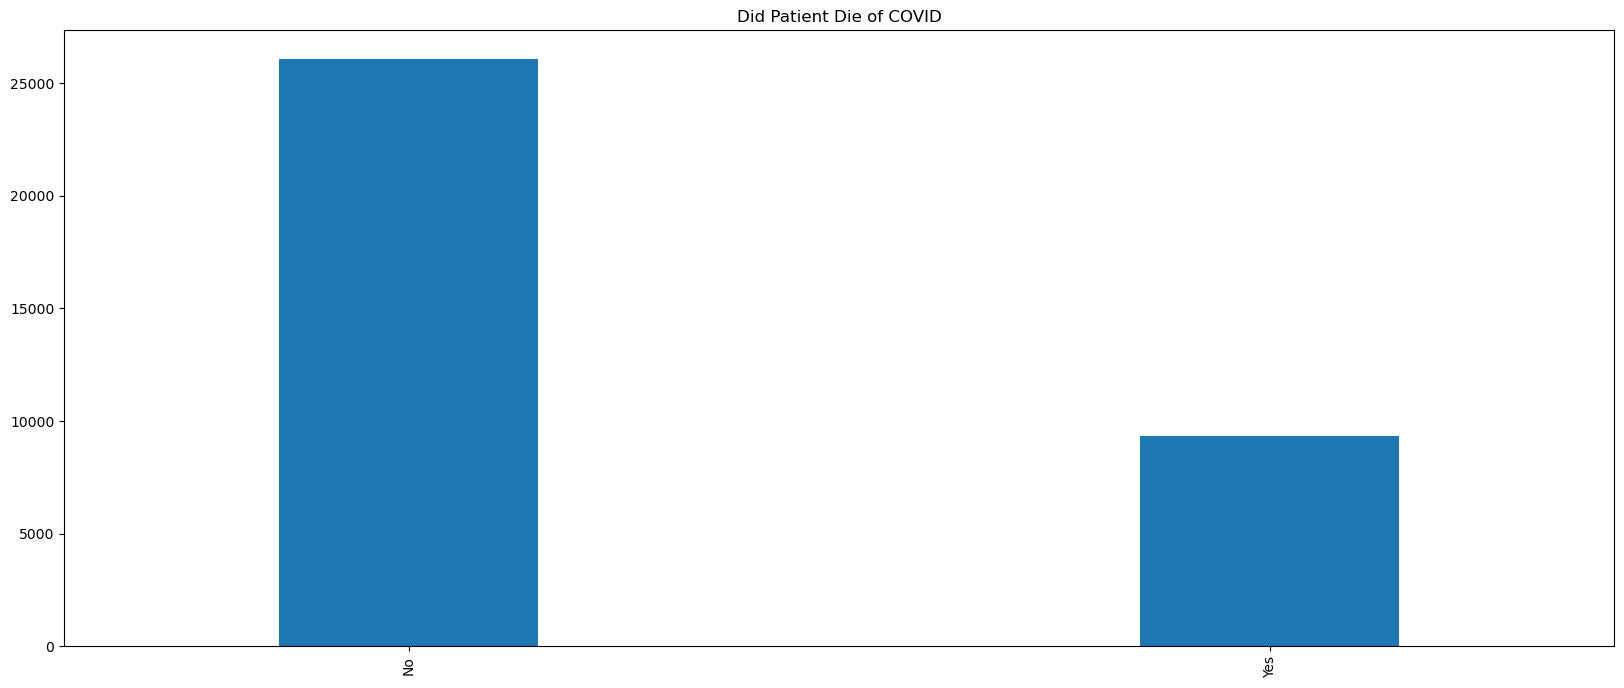

In [699]:
df['death_yn'].value_counts(dropna = False).plot(figsize=(20,8), kind='bar', width=0.3, title='Did Patient Die of COVID')

df['death_yn'].value_counts()

The data that we have operating under presents a death rate of 26110 non-deaths to 9355 deaths, for a total of 35,465 data points. This leaves us with an approximate death ratio of ~26.4 percent, and a non-death ratio of ~73.6 percent. This means that a simple model that predicts a non-death every single time would have an accuracy of around .736. Thankfully, all three of the models clear that bar easily, with accuracies of .88, .90, and .91 respectively. When it comes to the question of which model in particular is best for this specific problem, however, the answer becomes a bit more complicated. Before we continue, please refer to the statistics below.

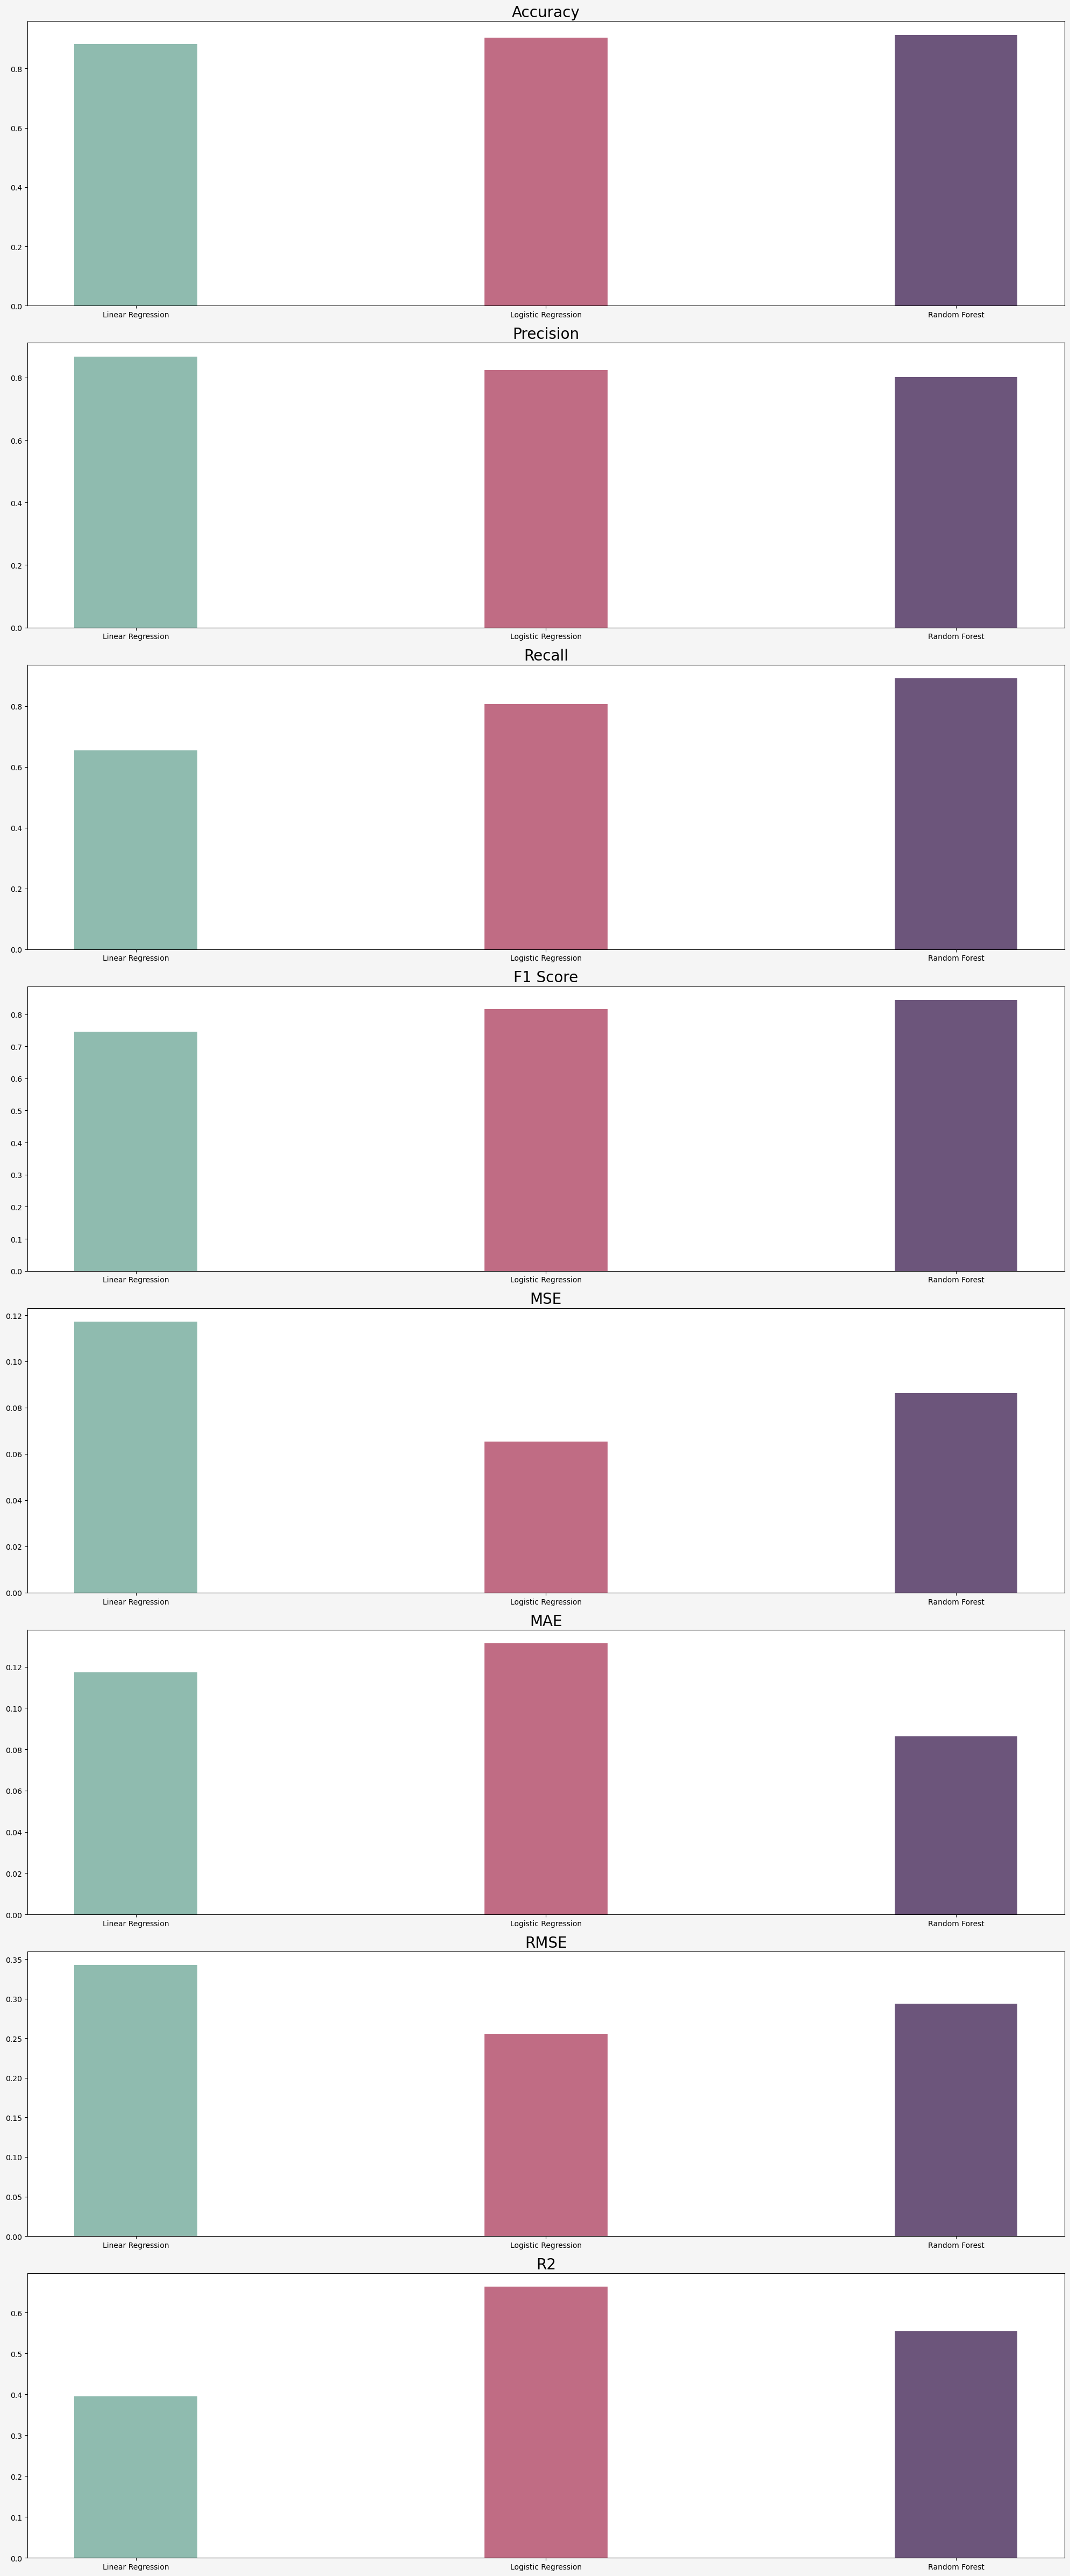

In [700]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE', 'RMSE', 'R2']
models = ['Linear Regression', 'Logistic Regression', 'Random Forest']
num_models = len(models)

data = np.array([list_of_linear_regression_training_stats, 
                 list_of_logistic_regression_training_stats, 
                 list_of_random_forest_training_stats])

fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(20, 6 * len(metrics)))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for model in range(num_models):
        ax.bar(models[model], data[model, i], width=0.3, color=['#8FBBAF', '#C06C84', '#6C557B'][model])
    fig.set_facecolor('#f5f5f5')    
    ax.set_title(metric, fontsize=20)

plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()

In [701]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE', 'RMSE', 'R2']
models = ['Linear Regression', 'Logistic Regression', 'Random Forest']

data = np.array([list_of_linear_regression_training_stats, 
                 list_of_logistic_regression_training_stats, 
                 list_of_random_forest_training_stats])

for i, metric in enumerate(metrics):
    print(f"\n{metric}:")
    print('='*30)
    for j, model in enumerate(models):
        value = data[j, i]
        print(f"{model}: {value}")



Accuracy:
Linear Regression: 0.8827951339772865
Logistic Regression: 0.9038111789192903
Random Forest: 0.9136725538536151

Precision:
Linear Regression: 0.8677399633177094
Logistic Regression: 0.82425003926496
Random Forest: 0.802127953571922

Recall:
Linear Regression: 0.6541711476417268
Logistic Regression: 0.8062682439698878
Random Forest: 0.8918420648333077

F1 Score:
Linear Regression: 0.7459705676243868
Logistic Regression: 0.8151599875737807
Random Forest: 0.8446093408991706

MSE:
Linear Regression: 0.11720486602271349
Logistic Regression: 0.06534586545947517
Random Forest: 0.08632744614638484

MAE:
Linear Regression: 0.11720486602271349
Logistic Regression: 0.131324632320077
Random Forest: 0.08632744614638484

RMSE:
Linear Regression: 0.3423519622007642
Logistic Regression: 0.25562837373710134
Random Forest: 0.2938153266022466

R2:
Linear Regression: 0.39541950613415633
Logistic Regression: 0.662924953952643
Random Forest: 0.554695194862951


As we can observe, each model has different points where they excel, and where they are outstripped by other models. Below, a breif overview of each of the models will be provided.

<b>Linear Regression</b>: The linear regression model presented with an overall accuracy of .88. It scored comparatively highly on measures like precision, but comparatively poorly on measures like recall, MSE, R2, and RMSE. In the confusion matrix for the set of test data, it had a false negative rate of around 7.5 percent, which is an important metric to keep in minf for this particular task, given that it indicates a prediction of survival that ended up turning out false. Interestingly, it performed comparatively highly in the MSE scores provided by the K-Fold cross validation, in which it posted the best results out of all three models, indicating that it applied well to random sets of data, and therefore potentially new datasets as well.

<b>Logistic Regression</b>: The logistic regression model presented with an overall accuracy of .90. It scored comparatively highly on measures like MSE, RMSE and R2, and comparatively poorly on measures like MAE. In most other metrics it was middling. Out of all the models, it performed worst in the K-Fold cross validation analysis. The false negative ratio on the test data confusion matrix was around 4.5 percent, meaning that it performed better than the linear regression model.

<b>Random Forest</b>: The random forest model presented with an overal accuracy of .91, the highest out of all the models. It performed comparatively highly on measures like recall and MAE, and comparatively poorly on measures like precision. Other measures were middling, including performance on the K-Fold cross validation. The false negative ratio was around 2 percent, the lowest of all the models, which in our scenario is very pleasing. False negatives are something we should look to minimise as much as possible.

As you can see, all of the models have measures that they excel at, and measures that the struggle on. The difficult of the comparisons is exacerbated by the minuteness of the differences, often representing only single digit percentage differences. Ultimately, however, we have come to the conclusion that the <b>Random Forest</b> model is the best implementation for this particular problem.

While some of it's measures fall short compared to other models, the high accuracy, very low rate of false negatives, and decent performance of the K-Fold cross validation give us confidence that this model would be the best suited to predicting whether a case of COVID-19 in a particular patient would be leathal or not, while minimizing dangerous false engatives that could pose a threat to a vulnerable person's health.

## 5.2 How can we improve our models?

Improving the performance of our models can be achieved through various approaches. Here is a list of changes we made to our model to try and improve our model's performance

<b>Adding Sociological Features to our Model</b>: Including sociological features such as race, ethnicity, and sex, could better capture the impact of social determinants on the target variable. These factors might have a significant influence on the outcomes and can lead to better predictions when included in the model.

<b>Feature Rescaling</b>: Rescaling features can improve their performance by ensuring that no single feature dominates the learning process. Standardising or normalizing the features can help in such cases. Note that tree-based models, like random forests, are usually not affected by the scale of the features.

<b>Removing Redundant Features</b>: Removing features that are highly correlated with other features or have very little predictive power can simplify the model, reduce overfitting, and improve generalisation.

<b>Adding Additional Health-Related Features to our Model</b>: Including more health-related features that are relevant to the target variable might help improve the model's performance. For example, incorporating the exposure_yn feature and the case_poistive_interval feature could be beneficial  to predicting our target feature.

## 5.2.1 Adding Sociological Features to our Model

Our initial set of models had a fairly restricted set of features that we were fairly confindent would lead to solid results. For our first model in section 5.2, we have elected to try a wider feature selection in order to hopefully get a better result. Specifically, this implementation will be adding in some of the sociological data back into the model. The two features that will now be incuded in the independent variables are sex and race, due to their easy translation to numerical values and the relatively high quality of the datasets.

In [702]:
STrain, STest = train, test

In [703]:
STrain.shape

(24743, 15)

In [704]:
STest.shape

(10605, 15)

In [705]:
#Mapping for new features in data

#Sex Map
sex_map = {
    'Male': 0,
    'Female': 1,
    'Unknown': 2
}

STrain['sex'] = STrain['sex'].map(sex_map)
STest['sex'] = STest['sex'].map(sex_map)

In [706]:
#Race Map

race_map = {
    'American Indian/Alaska Native': 0,
    'Asian': 1,
    'Black': 2,
    'Multiple/Other': 3,
    'Native Hawaiian/Other Pacific Islander': 4,
    'White': 5
}

STrain['race'] = STrain['race'].map(race_map)
STest['race'] = STest['race'].map(race_map)

To recap: The new selected features are Age Group, Case Month, hospitalization Status, Underlying Conditions, Race, and Sex

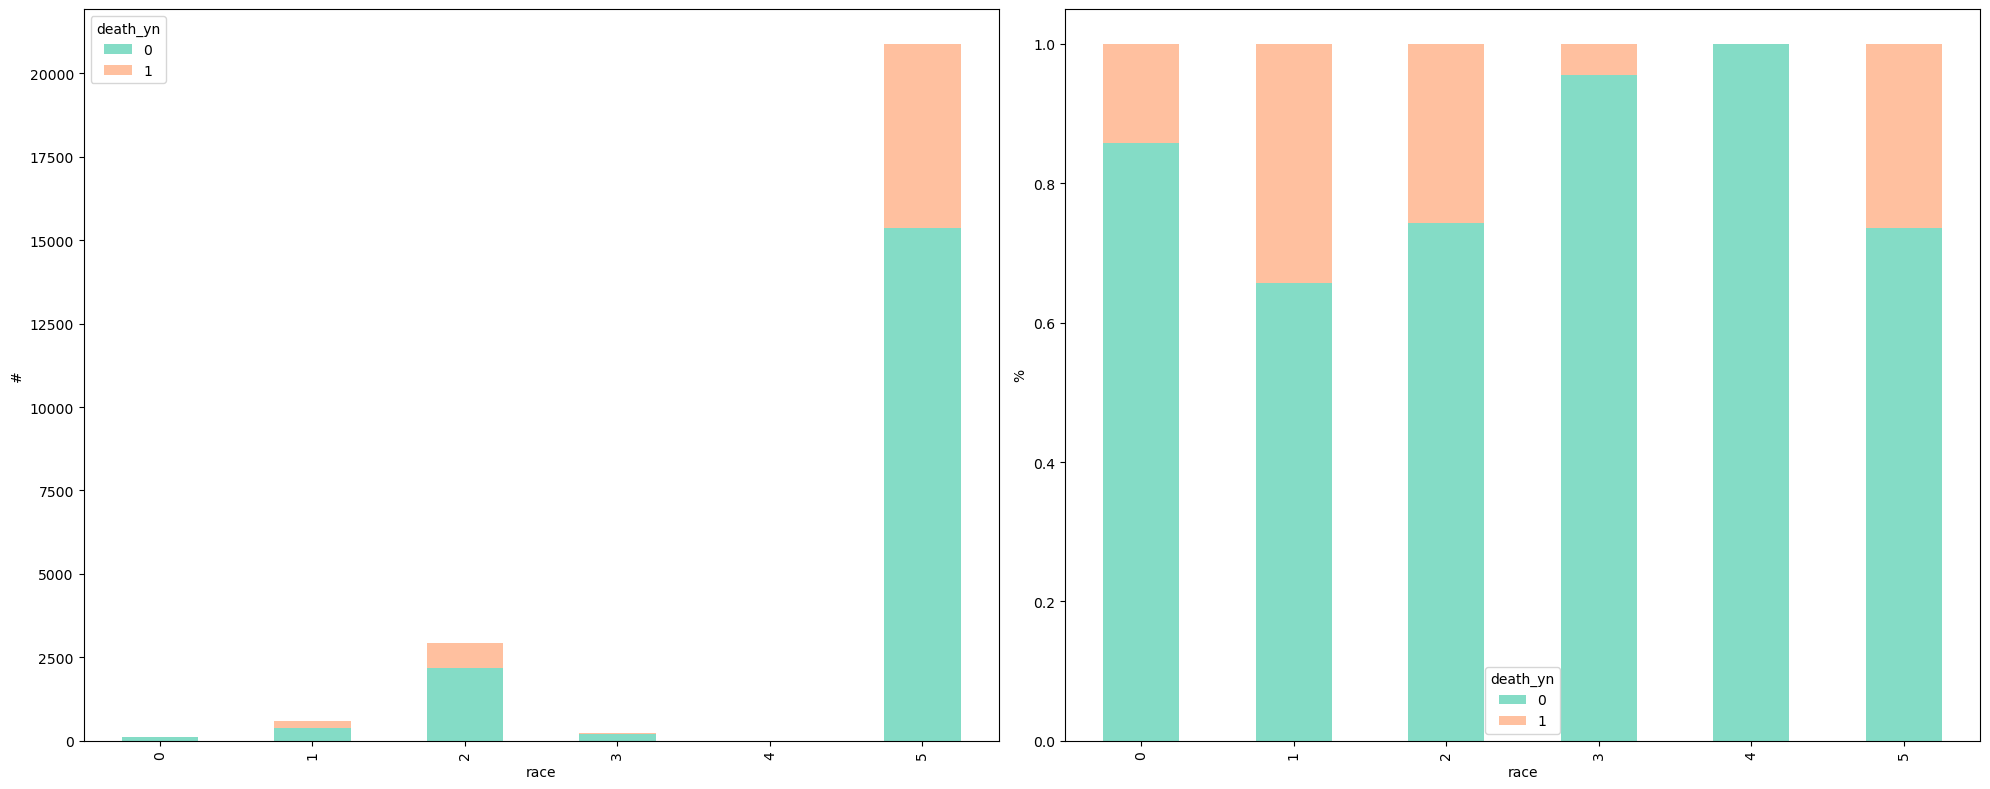

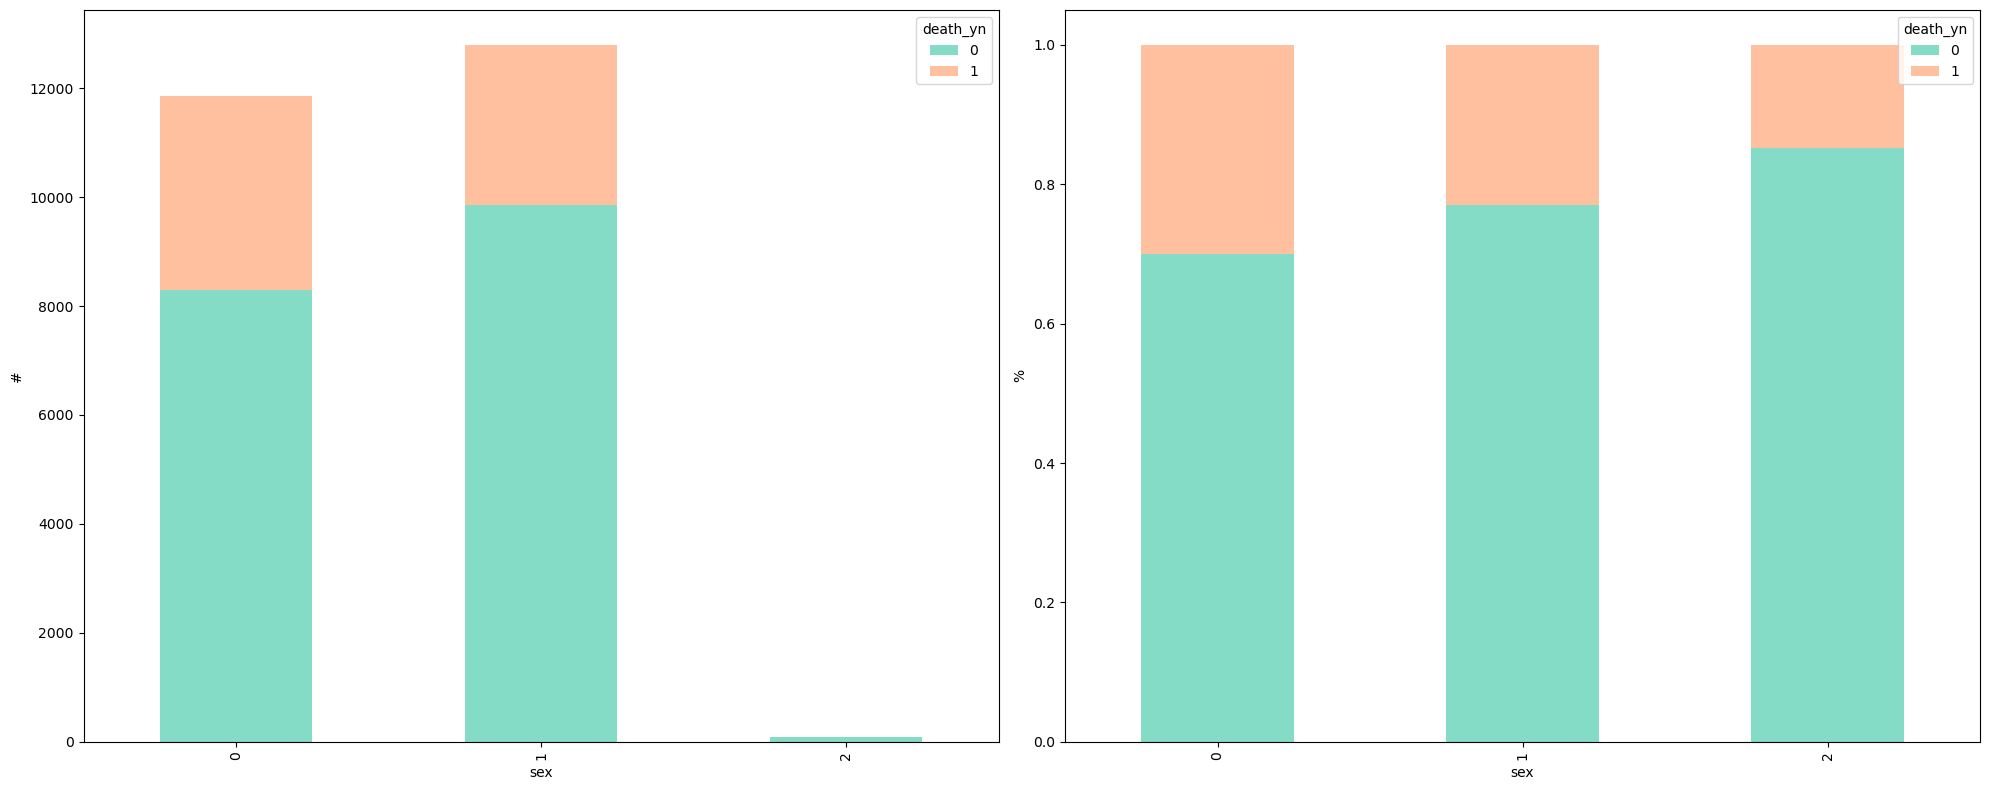

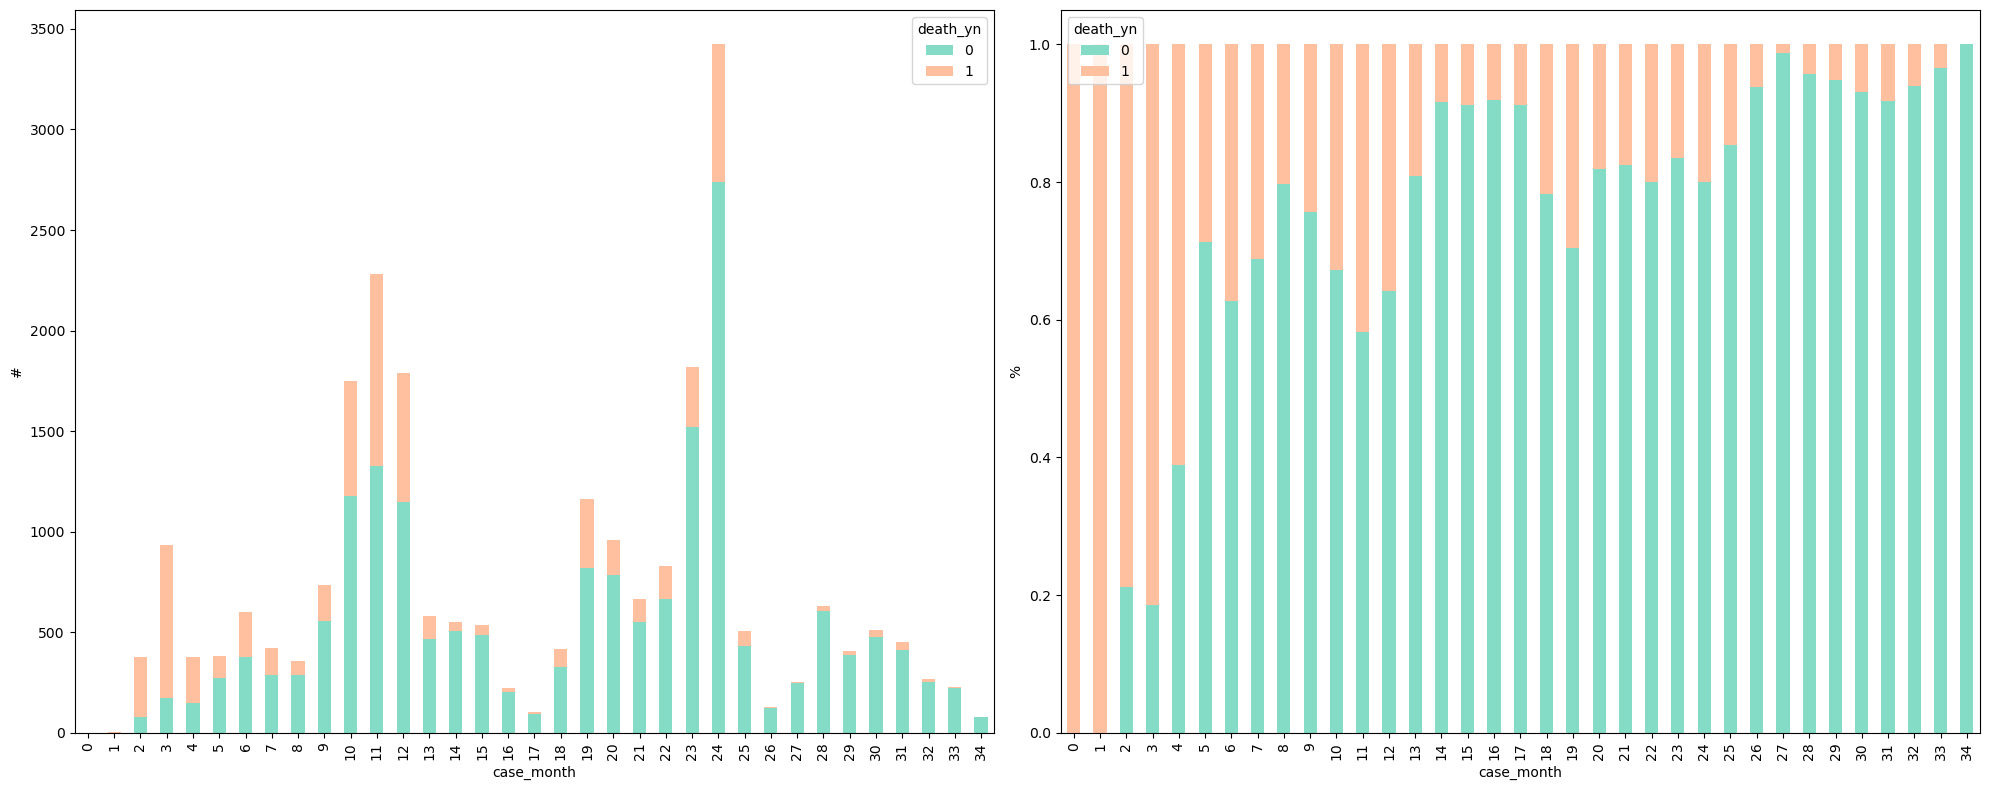

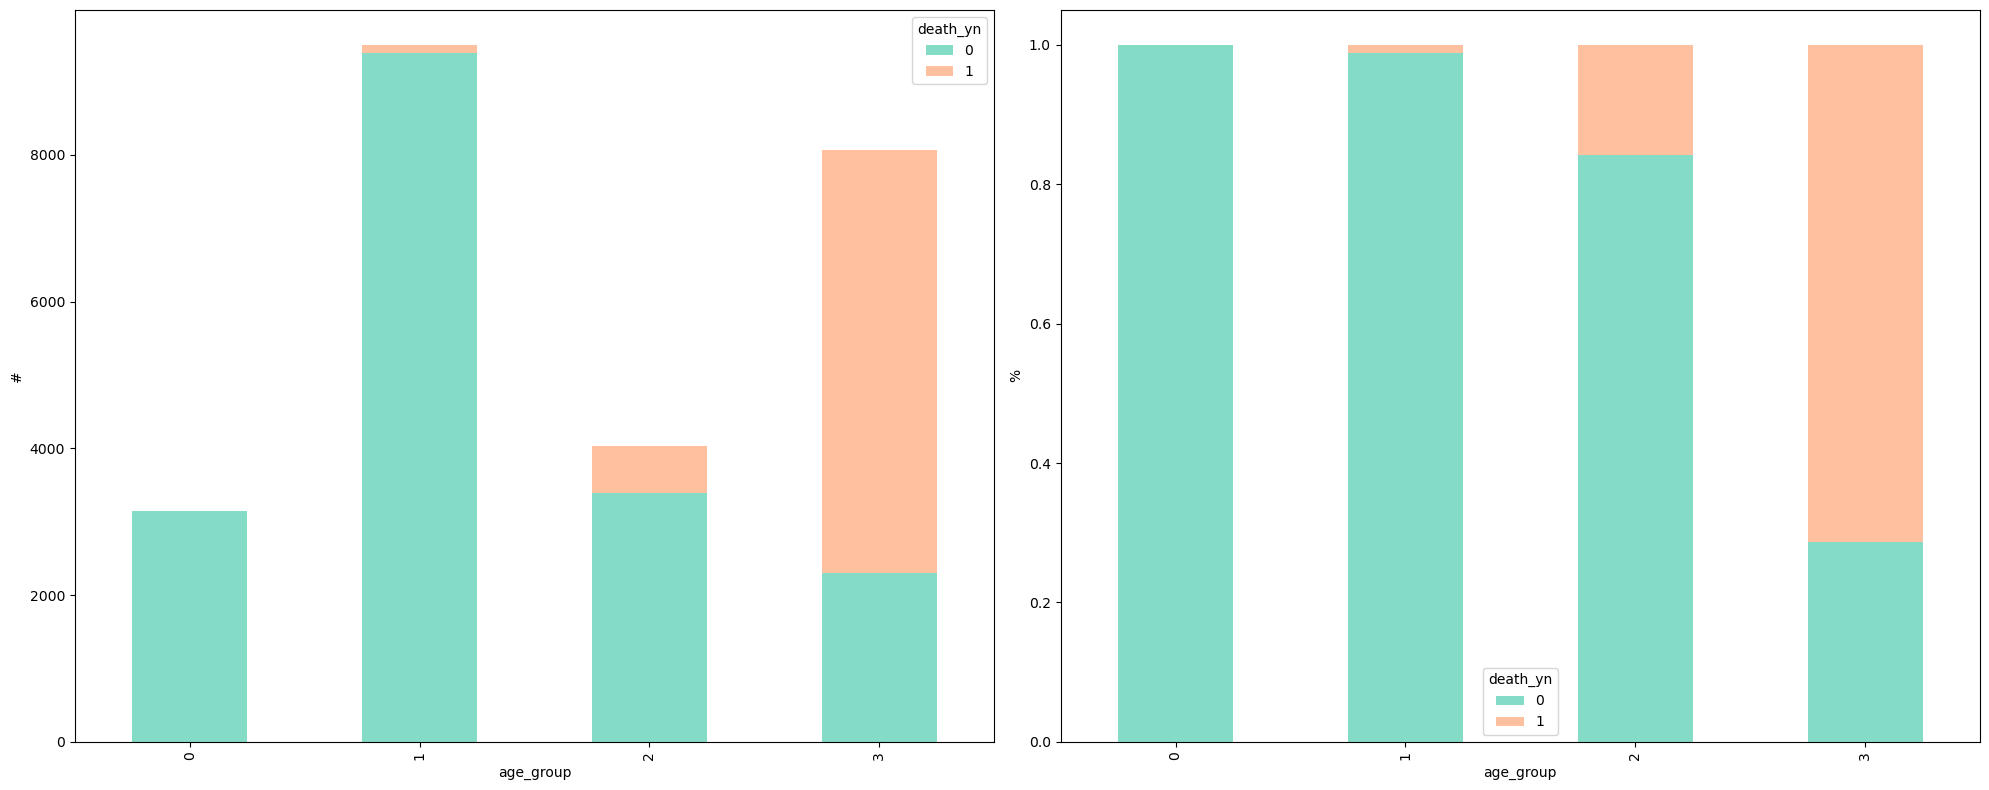

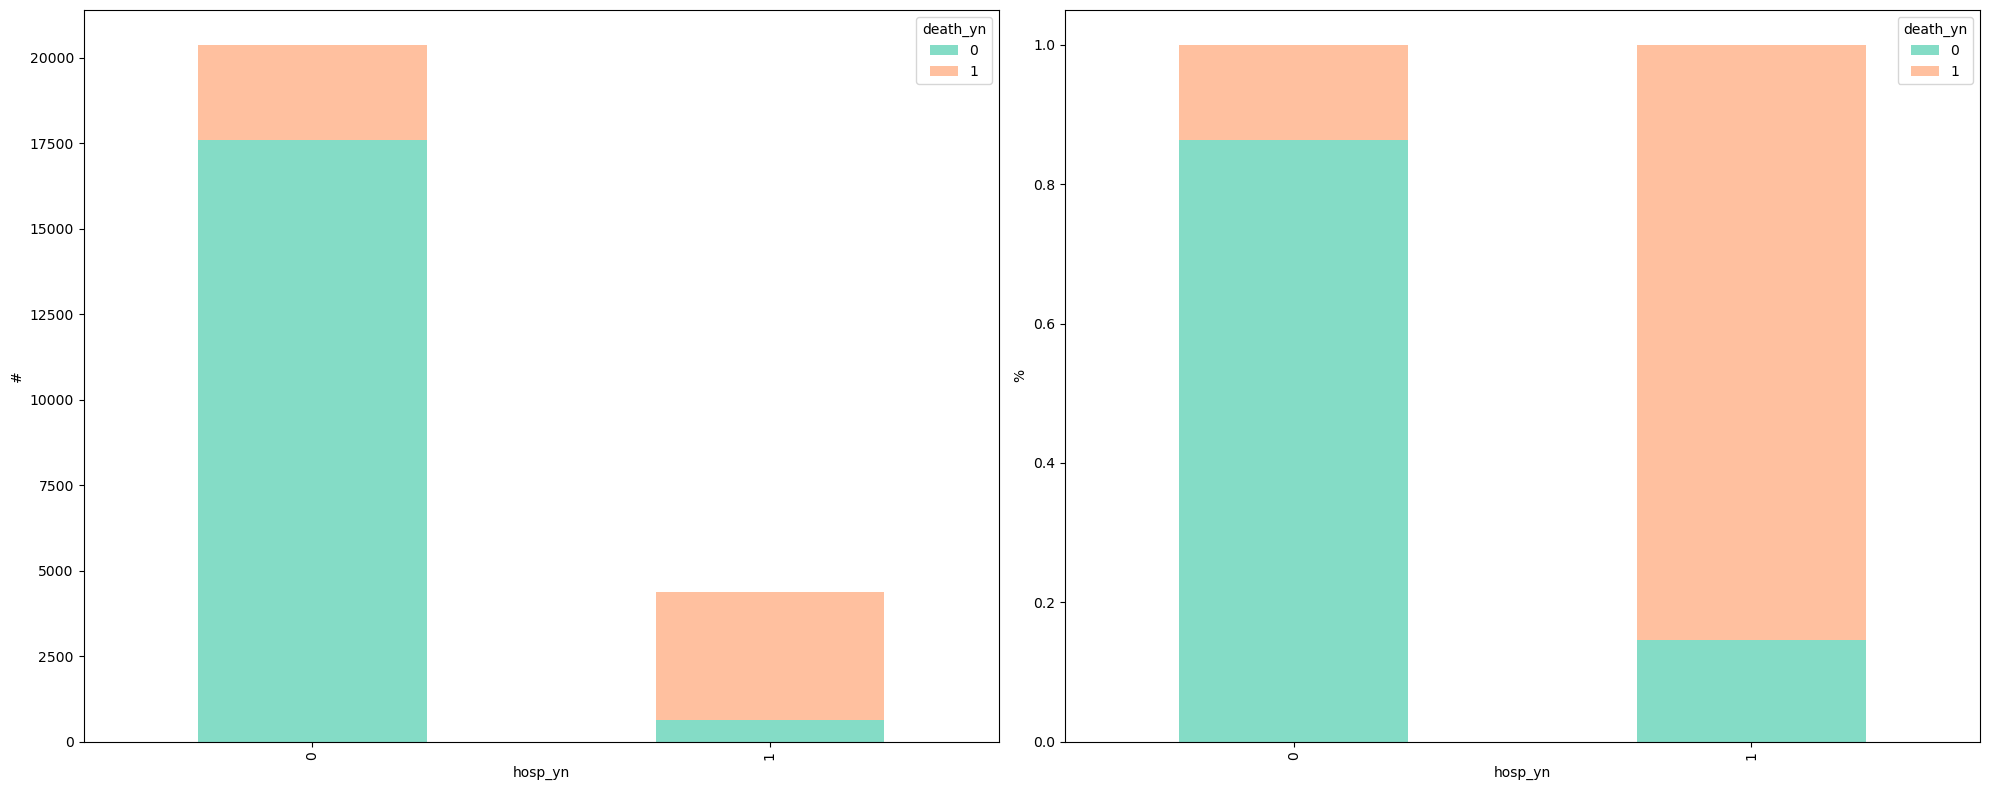

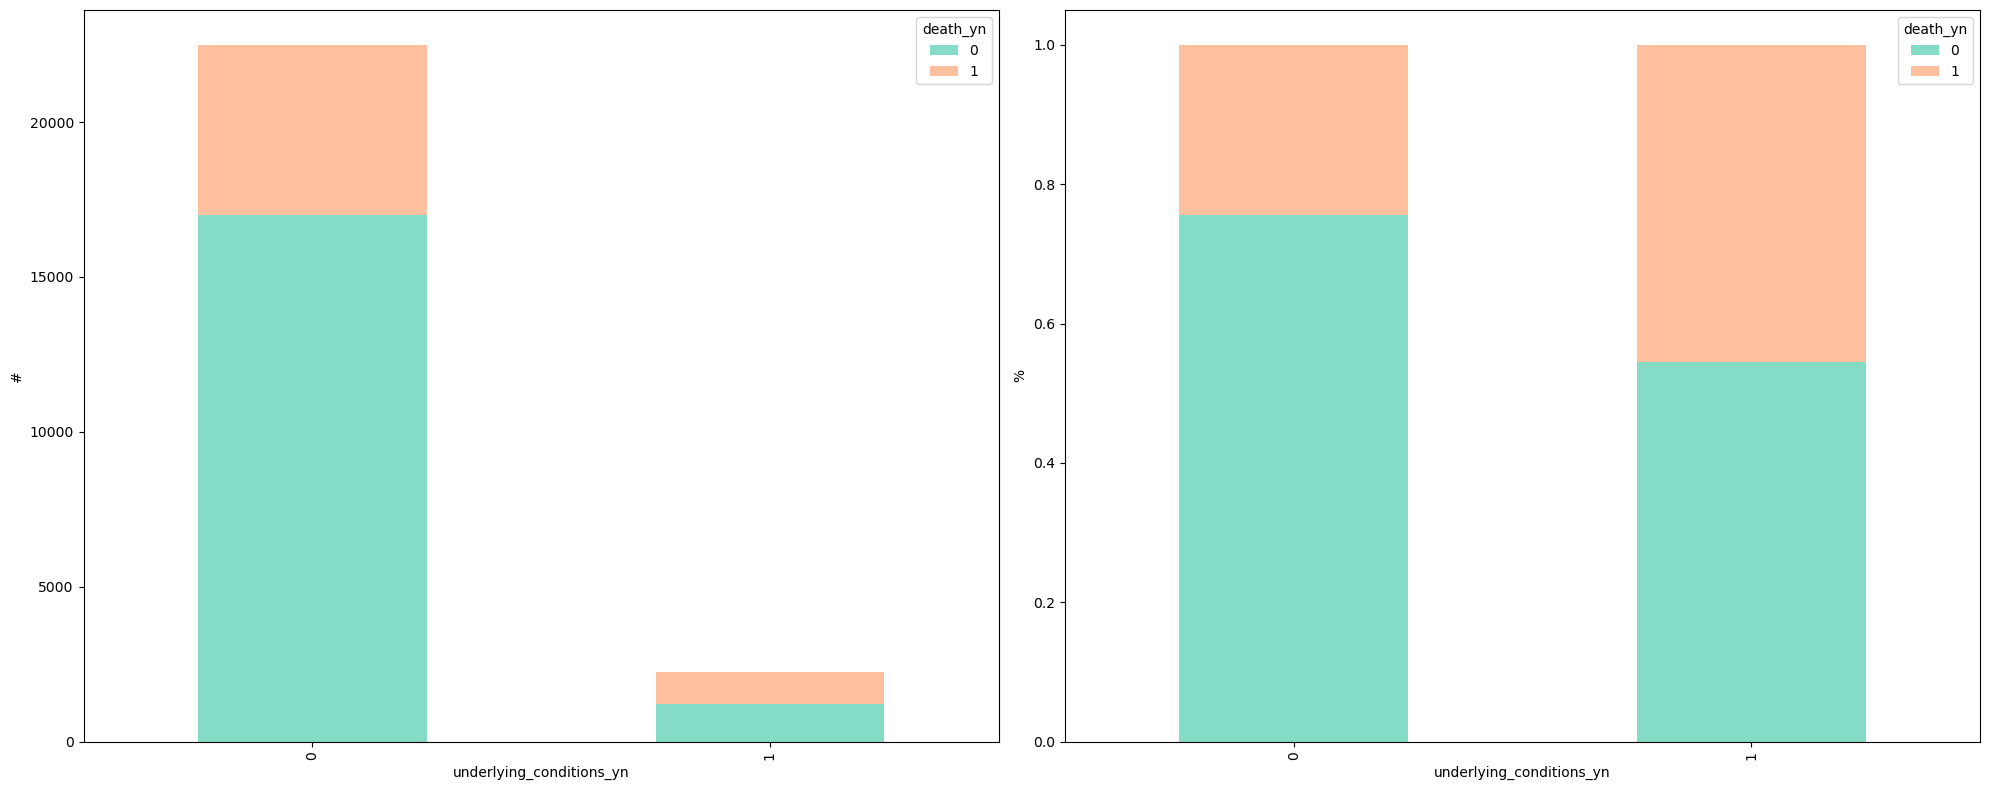

In [707]:
target_features = [STrain['race'], STrain['sex'], STrain['case_month'], STrain['age_group'], STrain['hosp_yn'], STrain['underlying_conditions_yn']]
select_features = [STrain['death_yn']]

colours = ['#84dcc6', '#ffc09f']

for target_feature in target_features:

    for feature in select_features:

        fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
        train.groupby([target_feature, feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0], color=colours)
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
        axs[0].set_ylabel('#')

        train.groupby([target_feature, feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1], color=colours)
        axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
        axs[1].set_ylabel('%')
        
        plt.tight_layout()
        plt.show()

In [708]:
#training and testing data
sociological_x_train = STrain[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'race', 'sex']]
sociological_y_train = STrain['death_yn']

sociological_x_test = STest[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'race', 'sex']]
sociological_y_test = STest['death_yn']

In [709]:
#fitting the model with new data
srfc = RandomForestClassifier(n_estimators=100, random_state=42)
srfc.fit(sociological_x_train, sociological_y_train)
sociological_y_pred = srfc.predict(sociological_x_test)

In [710]:
#Feature importance in the new random forest model
feature_importance = pd.DataFrame({'Feature': sociological_x_train.columns, 'Significance':srfc.feature_importances_})
feature_importance.sort_values('Significance', ascending=False)

,Feature,Significance
1,age_group,0.523144
2,hosp_yn,0.262682
0,case_month,0.156503
3,icu_yn,0.032224
5,race,0.010232
4,underlying_conditions_yn,0.007892
6,sex,0.007324


It seems that the new features have sorted themselves near to the bottom in terms of feature significance. It is interesting that sex is wieghted the lowest, given that there are fairly well know discrepancies in death rates between men and women. It is also intersting that race has been weighted more highly then having an underlying condition. Whether this is a reflection of relaity or not is debateable, given that our and many other groups have found the underlying_conditions data to be quite finicky. On the other hnad, if it is factual, then there are certainly sociological and socioeconomic factors at play in America that might contribute to this result.

In [711]:
#Predicting the first 10 results

sociological_y_train_pred_10 = srfc.predict_proba(sociological_x_train)[:, 1][:10]
sociological_y_train_pred_class_10 = (srfc.predict(sociological_x_train[:10]) > 0.5).astype(int)

sociological_output_df = pd.DataFrame({
    "Predicted Values": sociological_y_train_pred_10,
    "Predicted Class": sociological_y_train_pred_class_10
})

print(sociological_output_df)

   Predicted Values  Predicted Class
0          0.838223                1
1          0.942712                1
2          0.015440                0
3          0.680557                1
4          0.000000                0
5          0.020675                0
6          0.056575                0
7          0.000000                0
8          0.000000                0
9          0.000000                0


In [712]:
# predict target feature values for full training set
sociological_y_train_pred = srfc.predict_proba(sociological_x_train)[:, 1]

#threshold predicted target feature values at 0.5 to get predicted class for full training set
sociological_y_train_pred_class = (sociological_y_train_pred >= 0.5).astype(int)

sociological_accuracy_train = accuracy_score(sociological_y_train, sociological_y_train_pred_class)
sociological_precision_train = precision_score(sociological_y_train, sociological_y_train_pred_class)
sociological_recall_train = recall_score(sociological_y_train, sociological_y_train_pred_class)
sociological_f1_train = f1_score(sociological_y_train, sociological_y_train_pred_class)

sociological_confusion_train = confusion_matrix(sociological_y_train, sociological_y_train_pred_class)

sociological_mae_train = mean_absolute_error(sociological_y_train, sociological_y_train_pred_class)
sociological_mse_train = mean_squared_error(sociological_y_train, sociological_y_train_pred_class)
sociological_rmse_train = np.sqrt(sociological_mse_train)
sociological_r2_train = r2_score(sociological_y_train, sociological_y_train_pred_class)

print("\nEvaluation metrics on the training set:")
print("Accuracy: {:.2f}".format(sociological_accuracy_train))
print("Precision: {:.2f}".format(sociological_precision_train))
print("Recall: {:.2f}".format(sociological_recall_train))
print("F1 score: {:.2f}".format(sociological_f1_train))
print()
print("Confusion matrix:\n", sociological_confusion_train)
print()
print("Mean Squared Error: {:.2f}".format(sociological_mse_train))
print("Mean Absolute Error: {:.2f}".format(sociological_mae_train))
print("R2 score: {:.2f}".format(sociological_r2_train))
print("Root Mean Squared Error: {:.2f}".format(sociological_rmse_train))

list_of_sociological_training_stats = [sociological_accuracy_train, sociological_precision_train, sociological_recall_train, sociological_f1_train, sociological_mse_train, sociological_mae_train, sociological_rmse_train, sociological_r2_train]


Evaluation metrics on the training set:
Accuracy: 0.92
Precision: 0.82
Recall: 0.89
F1 score: 0.85

Confusion matrix:
 [[16943  1291]
 [  700  5809]]

Mean Squared Error: 0.08
Mean Absolute Error: 0.08
R2 score: 0.58
Root Mean Squared Error: 0.28


In [713]:
# Calculate the total number of instances
total_instances = np.sum(sociological_confusion_train)
sociological_confusion_train_percentage = (sociological_confusion_train / total_instances) * 100
print("Confusion matrix as a percentage:\n", sociological_confusion_train_percentage)

Confusion matrix as a percentage:
 [[68.47593259  5.21763731]
 [ 2.82908297 23.47734713]]


In [714]:
# predict target feature values for full testing set
sociological_y_test_pred = srfc.predict_proba(sociological_x_test)[:, 1]
# threshold predicted target feature values at 0.5 to get predicted class for full testing set
sociological_y_test_pred_class = (sociological_y_test_pred >= 0.5).astype(int)

sociological_accuracy_test = accuracy_score(sociological_y_test, sociological_y_test_pred_class)
sociological_precision_test = precision_score(sociological_y_test, sociological_y_test_pred_class)
sociological_recall_test = recall_score(sociological_y_test, sociological_y_test_pred_class)
sociological_f1_test = f1_score(sociological_y_test, sociological_y_test_pred_class)

sociological_confusion_test = confusion_matrix(sociological_y_test, sociological_y_test_pred_class)

sociological_mae_test = mean_absolute_error(sociological_y_test, sociological_y_test_pred_class)
sociological_mse_test = mean_squared_error(sociological_y_test, sociological_y_test_pred_class)
sociological_rmse_test = np.sqrt(sociological_mse_test)
sociological_r2_test = r2_score(sociological_y_test, sociological_y_test_pred_class)

print("\nEvaluation metrics on the testing set:")
print()
print("Accuracy: {:.2f}".format(sociological_accuracy_test))
print("Precision: {:.2f}".format(sociological_precision_test))
print("Recall: {:.2f}".format(sociological_recall_test))
print("F1 score: {:.2f}".format(sociological_f1_test))
print()
print("Confusion matrix:\n", sociological_confusion_test)
print()
print("Mean Squared Error: {:.2f}".format(sociological_mse_test))
print("Mean Absolute Error: {:.2f}".format(sociological_mae_test))
print("R2 score: {:.2f}".format(sociological_r2_test))
print("Root Mean Squared Error: {:.2f}".format(sociological_rmse_test))

list_of_sociological_testing_stats = [sociological_accuracy_test, sociological_precision_test, sociological_recall_test, sociological_f1_test, sociological_mse_test, sociological_mae_test, sociological_rmse_test, sociological_r2_test]


Evaluation metrics on the testing set:

Accuracy: 0.91
Precision: 0.80
Recall: 0.86
F1 score: 0.83

Confusion matrix:
 [[7203  603]
 [ 390 2409]]

Mean Squared Error: 0.09
Mean Absolute Error: 0.09
R2 score: 0.52
Root Mean Squared Error: 0.31


In [715]:
print("Classification Report:\n", classification_report(sociological_y_train, sociological_y_train_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94     18234
           1       0.82      0.89      0.85      6509

    accuracy                           0.92     24743
   macro avg       0.89      0.91      0.90     24743
weighted avg       0.92      0.92      0.92     24743



In [716]:
#performing 5 fold K-fold cross validation on sociological model using full dataset

#concatenating train and test datasets for independent and dependent variables
X = pd.concat([train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'race', 'sex']],
test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'race', 'sex']]])
y = pd.concat([train['death_yn'], test['death_yn']])

#folds for cross validation
folds = 5

#creating K-Fold object
kf = KFold(n_splits=folds, shuffle=True, random_state=42)

#K-fold cross validation scores
mse_scores = -cross_val_score(srfc, X, y, cv=folds, scoring="neg_mean_squared_error")

#printing results
print(f"MSE scores: {mse_scores}")

MSE scores: [0.08387553 0.09561528 0.09547383 0.09421417 0.0884142 ]


In [717]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MSE', 'MAE', 'RMSE', 'R2']

for i in range(len(metrics)):
    print(metrics[i])
    print('='*30)
    print('Trained Data: ', list_of_sociological_training_stats[i])
    print('Tested Data: ', list_of_sociological_testing_stats[i])
    print()

Accuracy
Trained Data:  0.9195327971547509
Tested Data:  0.9063649222065063

Precision
Trained Data:  0.818169014084507
Tested Data:  0.799800796812749

Recall
Trained Data:  0.8924565985558458
Tested Data:  0.8606645230439443

F1 Score
Trained Data:  0.8536997575134102
Tested Data:  0.8291171915332989

MSE
Trained Data:  0.08046720284524916
Tested Data:  0.09363507779349363

MAE
Trained Data:  0.08046720284524916
Tested Data:  0.09363507779349363

RMSE
Trained Data:  0.28366741590328837
Tested Data:  0.30599849312291333

R2
Trained Data:  0.5849242195562432
Tested Data:  0.5180206008569548



Adding in the sociological data has had some subtle but noticeable effects of the performance of the model. Though initally weighted low, the features have led to net accuracy gain of ~.005 on the training data and ~-.04 on the testing data. A similar trend plays out in the precision, recall, MSE, RMSE, and R2 measures, with a small gain in training data performance, and a small loss in testing data performance. There is a similar effect on the K-Fold cross validation tests, with a max score of just under .095, compared to a max score of just under 0.94. There was a very slight increase to the rate of false negatives, with a ratio of around 3.5% in the testing data.

Ultimate, this model seems to be largely on par with the previous random forest model. There seems to be a very slight net gain when using the training data, and a very slight loss when using the testing data, as might be expected from new features that were weighted relatively low. While it may not be a massive change over the previous random forest model, we beleive that these kinds of test models are still worth making and considering, as they prove the ability of our models to integrate new features without experiencing errors or massive losses to performance.

## 5.2.2 Feature Rescaling

Often feature rescaling can have a positive impact on a model's performance. However, the models that typically benefit from feature rescaling are models that rely on distance metrics, gradient-based optimisation, or regularisation.

In [718]:
scaler = MinMaxScaler()
random_forest_x_train_scaled = scaler.fit_transform(random_forest_x_train)
random_forest_x_test_scaled = scaler.transform(random_forest_x_test)
scaled_features_random_forest_model = RandomForestClassifier()
scaled_features_random_forest_model.fit(random_forest_x_train_scaled, random_forest_y_train)

scaled_random_forest_y_train_pred_class = scaled_features_random_forest_model.predict(random_forest_x_train_scaled)

scaled_random_forest_accuracy_train = accuracy_score(random_forest_y_train, scaled_random_forest_y_train_pred_class)
scaled_random_forest_precision_train = precision_score(random_forest_y_train, scaled_random_forest_y_train_pred_class)
scaled_random_forest_recall_train = recall_score(random_forest_y_train, scaled_random_forest_y_train_pred_class)
scaled_random_forest_f1_train = f1_score(random_forest_y_train, scaled_random_forest_y_train_pred_class)

scaled_random_forest_confusion_train = confusion_matrix(random_forest_y_train, scaled_random_forest_y_train_pred_class)

print("\nEvaluation metrics on the scaled training set:")
print()
print("Accuracy: {:.2f}".format(scaled_random_forest_accuracy_train))
print("Precision: {:.2f}".format(scaled_random_forest_precision_train))
print("Recall: {:.2f}".format(scaled_random_forest_recall_train))
print("F1 score: {:.2f}".format(scaled_random_forest_f1_train))
print()
print("Confusion matrix:\n", scaled_random_forest_confusion_train)


Evaluation metrics on the scaled training set:

Accuracy: 0.91
Precision: 0.80
Recall: 0.89
F1 score: 0.84

Confusion matrix:
 [[16802  1432]
 [  704  5805]]


In [719]:
print("\nEvaluation metrics on the original training set:")
print("Accuracy: {:.2f}".format(random_forest_accuracy_train))
print("Precision: {:.2f}".format(random_forest_precision_train))
print("Recall: {:.2f}".format(random_forest_recall_train))
print("F1 score: {:.2f}".format(random_forest_f1_train))
print()
print("Confusion matrix:\n", random_forest_confusion_train)


Evaluation metrics on the original training set:
Accuracy: 0.91
Precision: 0.80
Recall: 0.89
F1 score: 0.84

Confusion matrix:
 [[16802  1432]
 [  704  5805]]


With our <b>Random Forest</b> there is little to no difference once we refactor and normalise the feature values. <b>Random Forest</b>, as a decision-tree-based algorithm, is less sensitive to the scale of features compared to distance-based algorithms like Logistic Regression. scales.

## 5.2.3 Removing Redundant Features

Removing redundant features can improve the performance of a random forest model in several ways:

1. <b>Reduce Overfitting</b>: Redundant features can sometimes cause a model to be overly complex and overfit the training data, which in turn leads to poor generalization on unseen data. By removing such features, the model can potentially become more generalized and robust in its predictions.
2. <b>Reduce Noise</b>: Redundant features can sometimes introduce noise into the model's predictions, especially if they are highly correlated with other features or if they contain irrelevant information. Removing them can lead to better prediction accuracy.

In [720]:
feature_importance_table = pd.DataFrame({'Feature': random_forest_x_train.columns,
                                         'Significance': rfc.feature_importances_})

importance_threshold = 0.05
selected_features = []

for index, row in feature_importance_table.iterrows():
    if row['Significance'] >= importance_threshold:
        selected_features.append(row['Feature'])

# Filter the train and test datasets based on the selected features
filtered_x_train = train[selected_features]
filtered_x_test = test[selected_features]

# Train the new Random Forest model
filtered_random_forest_model = RandomForestClassifier()
filtered_random_forest_model.fit(filtered_x_train, random_forest_y_train)

# Make predictions
filtered_y_train_pred_class = filtered_random_forest_model.predict(filtered_x_train)
filtered_y_test_pred_class = filtered_random_forest_model.predict(filtered_x_test)

# Evaluate the model's performance
filtered_accuracy_train = accuracy_score(random_forest_y_train, filtered_y_train_pred_class)
filtered_precision_train = precision_score(random_forest_y_train, filtered_y_train_pred_class)
filtered_recall_train = recall_score(random_forest_y_train, filtered_y_train_pred_class)
filtered_f1_train = f1_score(random_forest_y_train, filtered_y_train_pred_class)
filtered_confusion_train = confusion_matrix(random_forest_y_train, filtered_y_train_pred_class)

feature_importance = pd.DataFrame({'Feature': filtered_x_train.columns, 'Significance':filtered_random_forest_model.feature_importances_})
feature_importance.sort_values('Significance', ascending=False)

,Feature,Significance
1,age_group,0.553763
2,hosp_yn,0.317470
0,case_month,0.128766


In [721]:
print("\nEvaluation metrics on the filtered training set:")
print()
print("Accuracy: {:.2f}".format(filtered_accuracy_train))
print("Precision: {:.2f}".format(filtered_precision_train))
print("Recall: {:.2f}".format(filtered_recall_train))
print("F1 score: {:.2f}".format(filtered_f1_train))
print()
print("Confusion matrix:\n", filtered_confusion_train)


Evaluation metrics on the filtered training set:

Accuracy: 0.91
Precision: 0.80
Recall: 0.89
F1 score: 0.84

Confusion matrix:
 [[16760  1474]
 [  748  5761]]


In [722]:
print("\nEvaluation metrics on the original training set:")
print("Accuracy: {:.2f}".format(random_forest_accuracy_train))
print("Precision: {:.2f}".format(random_forest_precision_train))
print("Recall: {:.2f}".format(random_forest_recall_train))
print("F1 score: {:.2f}".format(random_forest_f1_train))
print()
print("Confusion matrix:\n", random_forest_confusion_train)


Evaluation metrics on the original training set:
Accuracy: 0.91
Precision: 0.80
Recall: 0.89
F1 score: 0.84

Confusion matrix:
 [[16802  1432]
 [  704  5805]]


When comparing the performance of both the original random forest model and the retrained model that has removed 'redundant' features, the original model performs better. This indicates that the removed features, although having lower significance, still contributed to the overall predictive power of the model.

## 5.2.4 Adding Additional Health Related Features

In [723]:
additional_health_features_random_forest_x_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'exposure_yn', 'case_positive_specimen_interval']]
additional_health_features_random_forest_y_train = train['death_yn']

additional_health_features_random_forest_x_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'exposure_yn', 'case_positive_specimen_interval']]
additional_health_features_random_forest_y_test = test['death_yn']

additional_health_features_rfc = RandomForestClassifier(n_estimators=100, random_state=42)
additional_health_features_rfc.fit(additional_health_features_random_forest_x_train, additional_health_features_random_forest_y_train)
additional_health_random_forest_y_pred = additional_health_features_rfc.predict(additional_health_features_random_forest_x_test)

In [724]:
# predict target feature values for full training set
additional_health_feature_random_forest_y_train_pred = additional_health_features_rfc.predict_proba(additional_health_features_random_forest_x_train)[:, 1]

# threshold predicted target feature values at 0.5 to get predicted class for full training set
additional_health_features_random_forest_y_train_pred_class = (additional_health_feature_random_forest_y_train_pred >= 0.5).astype(int)

additional_health_features_random_forest_accuracy_train = accuracy_score(additional_health_features_random_forest_y_train, additional_health_features_random_forest_y_train_pred_class)
additional_health_features_random_forest_precision_train = precision_score(additional_health_features_random_forest_y_train, additional_health_features_random_forest_y_train_pred_class)
additional_health_features_random_forest_recall_train = recall_score(additional_health_features_random_forest_y_train, additional_health_features_random_forest_y_train_pred_class)
additional_health_features_random_forest_f1_train = f1_score(additional_health_features_random_forest_y_train, additional_health_features_random_forest_y_train_pred_class)

additional_health_features_random_forest_confusion_train = confusion_matrix(additional_health_features_random_forest_y_train, additional_health_features_random_forest_y_train_pred_class)

In [725]:
print("\nEvaluation metrics on the revised training set with additional health features:")
print("Accuracy: {:.2f}".format(additional_health_features_random_forest_accuracy_train))
print("Precision: {:.2f}".format(additional_health_features_random_forest_precision_train))
print("Recall: {:.2f}".format(additional_health_features_random_forest_recall_train))
print("F1 score: {:.2f}".format(random_forest_f1_train))
print()
print("Confusion matrix:\n", additional_health_features_random_forest_confusion_train)


Evaluation metrics on the revised training set with additional health features:
Accuracy: 0.92
Precision: 0.83
Recall: 0.88
F1 score: 0.84

Confusion matrix:
 [[17100  1134]
 [  812  5697]]


In [726]:
print("\nEvaluation metrics on the original training set:")
print("Accuracy: {:.2f}".format(random_forest_accuracy_train))
print("Precision: {:.2f}".format(random_forest_precision_train))
print("Recall: {:.2f}".format(random_forest_recall_train))
print("F1 score: {:.2f}".format(random_forest_f1_train))
print()
print("Confusion matrix:\n", random_forest_confusion_train)


Evaluation metrics on the original training set:
Accuracy: 0.91
Precision: 0.80
Recall: 0.89
F1 score: 0.84

Confusion matrix:
 [[16802  1432]
 [  704  5805]]


In [727]:
print("Random Forest Classifier with Additional Health Features Classification Report:\n", classification_report(additional_health_features_random_forest_y_train, additional_health_features_random_forest_y_train_pred_class))

Random Forest Classifier with Additional Health Features Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95     18234
           1       0.83      0.88      0.85      6509

    accuracy                           0.92     24743
   macro avg       0.89      0.91      0.90     24743
weighted avg       0.92      0.92      0.92     24743



While our overall accuracy is better with increased health features added to dataset for modelling, our recall score suffered with our model on average wrongly assigning a False Negative value to more users than our original dataset.